In [9]:
import os
import time
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import ast
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import h5py
import re
%matplotlib inline

# Paths

In [2]:
data_dir = '/arc/projects/unions/ssl/data/raw/tiles/dwarforge'
table_dir = '/arc/home/heestersnick/dwarforge/tables'
dwarf_cat_file_old = 'all_known_dwarfs_processed.csv'
dwarf_cat_file_new = 'all_known_dwarfs_v3_processed.csv'
dwarf_cat_new = pd.read_csv(os.path.join(table_dir, dwarf_cat_file_new))
dwarf_cat_old = pd.read_csv(os.path.join(table_dir, dwarf_cat_file_old))

# Functions

In [3]:
band_dict = {
    'cfis-u': {
        'name': 'CFIS',
        'band': 'u',
        'vos': 'vos:cfis/tiles_DR5/',
        'suffix': '.u',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
    'whigs-g': {
        'name': 'calexp-CFIS',
        'band': 'g',
        'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/',
        'suffix': '',
        'delimiter': '_',
        'fits_ext': 1,
        'zfill': 0,
        'zp': 27.0,
    },
    'cfis_lsb-r': {
        'name': 'CFIS_LSB',
        'band': 'r',
        'vos': 'vos:cfis/tiles_LSB_DR5/',
        'suffix': '.r',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
    'ps-i': {
        'name': 'PS-DR3',
        'band': 'i',
        'vos': 'vos:cfis/panstarrs/DR3/tiles/',
        'suffix': '.i',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
    'wishes-z': {
        'name': 'WISHES',
        'band': 'z',
        'vos': 'vos:cfis/wishes_1/coadd/',
        'suffix': '.z',
        'delimiter': '.',
        'fits_ext': 1,
        'zfill': 0,
        'zp': 27.0,
    },
    'ps-z': {
        'name': 'PSS.DR4',
        'band': 'ps-z',
        'vos': 'vos:cfis/panstarrs/DR4/resamp/',
        'suffix': '.z',
        'delimiter': '.',
        'fits_ext': 0,
        'zfill': 3,
        'zp': 30.0,
    },
}

def zfill_tile(tile):
    return f'{str(tile[0]).zfill(3)}_{str(tile[1]).zfill(3)}'

def transform_list(input_list):
    result = []
    for item in input_list:
        # Extract the numbers from the string using regex
        x, y = re.findall(r'\d+', item)
        
        # Format each number to a 3-digit format, adding leading zeros if necessary
        formatted_x = x.zfill(3)
        formatted_y = y.zfill(3)
        
        # Combine them with an underscore
        result.append(f"{formatted_x}_{formatted_y}")
    
    return result

def labels_to_df(parent_folder, tile_list, dwarf_df):
    k = 0
    unmatched_dwarf_counter = 0
    unmatched_tile_counter = 0
    additional_dwarf_counter = 0
    for tile in tqdm(tile_list):
        # Convert tile tuple to folder name format
        folder_name = zfill_tile(tile)
        
        # Construct the full path to the parquet file
        tile_nums_zfill = folder_name.split('_')
        file_path = os.path.join(parent_folder, folder_name, "cfis_lsb-r", f"CFIS_LSB.{tile_nums_zfill[0]}.{tile_nums_zfill[1]}.r_rebin_det_params.parquet")
        fits_name = f'CFIS_LSB.{tile_nums_zfill[0]}.{tile_nums_zfill[1]}.r_rebin_seg.fits'
        fits_path = os.path.join(parent_folder, folder_name, "cfis_lsb-r", fits_name)
        
        if os.path.exists(file_path):
            try:
                # Attempt to read the parquet file
                det_df = pd.read_parquet(file_path)
                det_df_updated = det_df.copy()
                dwarfs_in_tile = dwarf_df[dwarf_df['tile'] == str(tile)].reset_index(drop=True)
                _, header = open_fits(fits_path, fits_ext=0)
                additional_dwarfs = check_objects_in_neighboring_tiles(str(tile), dwarf_df, header)

                if not additional_dwarfs.empty:
                    dwarfs_in_tile = pd.concat([dwarfs_in_tile, additional_dwarfs]).reset_index(drop=True)

                det_idx_lsb, lsb_matches, lsb_unmatches, _ = match_cats(det_df_updated, dwarfs_in_tile, tile, header, max_sep=15.0)

                # add lsb labels to detections dataframe
                det_df_updated['lsb'] = np.nan
                det_df_updated['ID_known'] = np.nan

                if len(det_idx_lsb) > 0:
                    print(f'Found {len(det_idx_lsb)} lsb detections for tile {tile}.')
                    det_df_updated.loc[det_idx_lsb, 'lsb'] = 1
                    # Initialize the column to accept strings
                    det_df_updated['ID_known'] = det_df_updated['ID_known'].astype(object)
                    det_df_updated.loc[det_idx_lsb, 'ID_known'] = lsb_matches['ID'].values
                    # print(
                    #     f'Added {np.count_nonzero(~np.isnan(det_df_updated["lsb"]))} LSB labels to the detection dataframe for tile {tile}.'
                    # )
                    k += 1
                    additional_dwarf_counter += len(additional_dwarfs)

                if len(lsb_unmatches) > 0:
                    print(f'Found {len(lsb_unmatches)} unmatched dwarf for tile: {tile}.')
                    unmatched_tile_counter += 1
                    unmatched_dwarf_counter += len(lsb_unmatches)

                # Save updated dataframe
                det_df_updated.to_parquet(file_path, index=False)
            except Exception as e:
                print(f'Something went wrong for tile {tile}: {e}')
    print(f'Was able to match {k}/{len(tile_list)} tiles.')
    print(f'There were {unmatched_dwarf_counter} unmatched dwarfs in {unmatched_tile_counter} tiles.')
    print(f'{additional_dwarf_counter} dwarfs are in multiple tiles.')

def open_fits(file_path, fits_ext):
    """
    Open fits file and return data and header.

    Args:
        file_path (str): name of the fits file
        fits_ext (int): extension of the fits file

    Returns:
        data (numpy.ndarray): image data
        header (fits header): header of the fits file
    """
    # logger.debug(f'Opening fits file {os.path.basename(file_path)}..')
    with fits.open(file_path, memmap=True) as hdul:
        data = hdul[fits_ext].data.astype(np.float32)  # type: ignore
        header = hdul[fits_ext].header  # type: ignore
    # logger.debug(f'Fits file {os.path.basename(file_path)} opened.')
    return data, header
                
def check_objects_in_neighboring_tiles(tile, dwarfs_df, header):
    wcs = WCS(header)
    # Get neighboring tile numbers
    neighboring_tiles = get_neighboring_tile_numbers(tile)

    # Filter dwarfs in neighboring tiles
    neighboring_dwarfs = dwarfs_df[dwarfs_df['tile'].isin(neighboring_tiles)]

    # Check which of these dwarfs are actually within the current tile's boundaries
    dwarfs_in_current_tile = neighboring_dwarfs[
        neighboring_dwarfs.apply(
            lambda row: wcs.footprint_contains(
                SkyCoord(row['ra'], row['dec'], unit='deg', frame='icrs')
            ),
            axis=1,
        )
    ]

    return dwarfs_in_current_tile

def get_neighboring_tile_numbers(tile):
    tile = ast.literal_eval(tile)
    x, y = map(int, tile)
    neighbors = [
        (x - 1, y - 1),
        (x - 1, y),
        (x - 1, y + 1),
        (x, y - 1),
        (x, y + 1),
        (x + 1, y - 1),
        (x + 1, y),
        (x + 1, y + 1),
    ]
    return [f'({nx:03d}, {ny:03d})' for nx, ny in neighbors if 0 <= nx < 1000 and 0 <= ny < 1000]

def dwarfs_to_df(parent_folder):
    # Pattern to match all relevant parquet files
    pattern = os.path.join(parent_folder, "*_*", "cfis_lsb-r", "CFIS_LSB.*.r_rebin_det_params.parquet")
    
    # List to store filtered dataframes
    filtered_dfs = []
    
    # Iterate through all matching files
    for file in tqdm(glob(pattern)):
        try:
            # Attempt to read the parquet file
            df = pd.read_parquet(file)
            # Check if 'label' column exists
            if 'lsb' in df.columns:
                # Filter rows where label is 1
                df_filtered = df[df['lsb'] == 1]
                
                if not df_filtered.empty:
                    filtered_dfs.append(df_filtered)
            # If 'label' column doesn't exist, we skip this file
        
        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue
        
        # The file is automatically closed after reading
    
    # Combine all dataframes
    if filtered_dfs:
        final_df = pd.concat(filtered_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty dataframe if no data found

def gather_training_data(parent_folder, in_dict, band='cfis_lsb-r', n_neighbors=1, dwarf_tiles=None):
    zfill = in_dict[band]['zfill']
    file_prefix = in_dict[band]['name']
    delimiter = in_dict[band]['delimiter']
    suffix = in_dict[band]['suffix']

    if dwarf_tiles is None:
        pattern = os.path.join(parent_folder, "*_*", band, f"{file_prefix}{delimiter}*{suffix}_rebin_star_mask*_det_params.parquet")
        file_list = glob(pattern)
    else:
        file_list = []
        for tile in dwarf_tiles:
            tile_nums = tile.split('_')
            num1, num2 = tile_nums[0], tile_nums[1]
            pattern = os.path.join(parent_folder, tile, band, f'{file_prefix}{delimiter}{num1}{delimiter}{num2}{suffix}*_det_params.parquet')
            result = glob(pattern)
            if len(result) != 0:
                file_list.append(result[0])

    print(f'Found {len(file_list)} detection catalogs from tiles with dwarfs.')
            
    all_examples = []
    
    for file in tqdm(file_list):
        try:
            filename = os.path.basename(file)
            tile_numbers = filename.split(f'{delimiter}')[1:3]
            tile_id = f"{tile_numbers[0]}.{tile_numbers[1]}"
            
            df = pd.read_parquet(file)
            
            if 'lsb' in df.columns:
                positive_examples = df[df['lsb'] == 1].copy()
                potential_negatives = df[df['lsb'].isna()].copy()
                
                if not positive_examples.empty and not potential_negatives.empty:
                    nn = NearestNeighbors(n_neighbors=len(potential_negatives), metric='euclidean')
                    nn.fit(potential_negatives[['ra', 'dec']])
                    
                    used_negatives = set()  # Set to keep track of used negative examples in this field
                    all_file_examples = []
                    
                    for idx, lsb_obj in positive_examples.iterrows():
                        lsb_df = pd.DataFrame({'ra': [lsb_obj['ra']], 'dec': [lsb_obj['dec']]})
                        
                        distances, indices = nn.kneighbors(lsb_df)
                        
                        # Find n_neighbors unique negative examples within this field
                        unique_negatives = []
                        for index in indices[0]:
                            if index not in used_negatives:
                                unique_negatives.append(index)
                                used_negatives.add(index)
                                if len(unique_negatives) == n_neighbors:
                                    break
                        
                        # If we couldn't find enough unique negatives, continue to the next positive example
                        if len(unique_negatives) < n_neighbors:
                            continue
                        
                        nearest_neighbors = potential_negatives.iloc[unique_negatives].copy()
                        
                        lsb_obj['example_id'] = f"{tile_id}.{lsb_obj['ID']}"
                        
                        nearest_neighbors['example_id'] = nearest_neighbors['ID'].apply(lambda x: f"{tile_id}.{x}")
                        nearest_neighbors['lsb'] = 0  # Set to 0 for negative examples
                        nearest_neighbors['associated_lsb_ra'] = lsb_obj['ra']
                        nearest_neighbors['associated_lsb_dec'] = lsb_obj['dec']
                        
                        all_file_examples.append(pd.concat([lsb_obj.to_frame().T, nearest_neighbors]))
                    
                    if all_file_examples:
                        all_examples.append(pd.concat(all_file_examples))
            
        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue
    
    if all_examples:
        final_df = pd.concat(all_examples, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

def create_cartesian_kdtree(ra, dec):
    """
    Create a KD-Tree using Cartesian coordinates converted from RA and Dec.
    
    :param ra: Right Ascension in degrees
    :param dec: Declination in degrees
    :return: cKDTree object and the corresponding SkyCoord object
    """
    coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
    xyz = coords.cartesian.xyz.value.T
    tree = cKDTree(xyz)
    return tree, coords

def match_cats(df_det, df_label, tile, pixel_scale, max_sep=15.0, re_multiplier=4.0):
    tree, _ = create_cartesian_kdtree(df_det['ra'].values, df_det['dec'].values)
    matches = []
    potential_matches_df = pd.DataFrame()
    for idx, known in df_label.iterrows():
        known_coords = SkyCoord(known['ra'], known['dec'], unit='deg')
        known_coords_xyz = known_coords.cartesian.xyz.value
        
        # Calculate base search radius in degrees
        base_search_radius = max_sep / 3600  # Convert arcseconds to degrees
        
        # Adaptive search radius (if 're' is available)
        if 're' in known and known['re'] is not None and not np.isnan(known['re']) and known['re'] > 0:
            adaptive_radius = known['re'] * re_multiplier / 3600  # Convert to degrees
            search_radius = max(base_search_radius, adaptive_radius)
        else:
            search_radius = base_search_radius
            
        search_radius_chord = 2 * np.sin(np.deg2rad(search_radius) / 2)
        
        potential_match_indices = tree.query_ball_point(known_coords_xyz, search_radius_chord)
        potential_matches = df_det.iloc[potential_match_indices]
        
        print(f'potential matches for {known["ID"]}: {len(potential_matches)}')
        
        potential_matches_df = pd.concat([potential_matches_df, potential_matches])
        if len(potential_matches) > 0:
            potential_matches_coords = SkyCoord(potential_matches['ra'], potential_matches['dec'], unit='deg')
            distances = known_coords.separation(potential_matches_coords).arcsec
            max_n_pix = potential_matches['n_pix'].max()
            max_mu = potential_matches['mu'].max()
            scores = []
            for i, det in potential_matches.iterrows():
                size_score = np.log1p(det['n_pix']) / np.log1p(max_n_pix)
                lsb_score = det['mu'] / max_mu
                distance = distances[potential_matches.index.get_loc(i)]
                distance_score = 1 - (distance / (3600 * search_radius))  # Normalized distance score
                score = (
                    lsb_score * 0.2
                    + size_score * 0.4
                    + distance_score * 0.4
                )
                print(f'object: {det["ID"]}; lsb score: {lsb_score:.4f}, size score: {size_score:.4f}, distance score: {distance_score:.4f}')
                print(f'object: {det["ID"]}; total score: {score:.4f}; distance: {distance:.2f} arcsec')
                scores.append((i, score, distance))
            best_match = max(scores, key=lambda x: x[1])
            matches.append((idx, best_match[0], best_match[2]))
    
    if matches:
        label_match_idx, det_match_idx, match_distances = zip(*matches)
    else:
        label_match_idx, det_match_idx, match_distances = [], [], []
    label_matches = df_label.loc[list(label_match_idx)].reset_index(drop=True)
    label_unmatches = df_label.drop(list(label_match_idx)).reset_index(drop=True)
    det_matches = df_det.loc[list(det_match_idx)].reset_index(drop=True)
    det_matches['match_distance'] = match_distances
    return list(det_match_idx), label_matches, label_unmatches, det_matches

def get_tile_list(dwarf_cat):
    tiles = dwarf_cat['tile'].values
    non_nan_tiles = [x for x in tiles if x is not np.nan]
    str_to_tuple = [ast.literal_eval(item) for item in non_nan_tiles]
    unique_tiles = list(set(str_to_tuple))
    return unique_tiles

def check_bands(bands_str, to_check):
    if isinstance(bands_str, str):
        if bands_str.startswith('['):
            # Handle string representation of a list
            try:
                bands_list = ast.literal_eval(bands_str)
                return all(band in bands_list for band in to_check)
            except:
                return False
        else:
            # Handle simple string format
            return all(band in bands_str for band in to_check)
    return False  # Return False for NaN values

def check_availability(dwarf_cat, check_for_bands):
    df_select = dwarf_cat.loc[(~dwarf_cat['tile'].isna()) & (dwarf_cat['bands'].apply(lambda x: check_bands(x, check_for_bands)))].reset_index(drop=True)
    return df_select

def check_param_filter_new(data: pd.DataFrame, a: float, b: float, band: str) -> pd.DataFrame:
    params_field = data.copy()
    df_dwarf = data.loc[data['lsb'] == 1].reset_index(drop=True)

    # Define band-specific conditions
    band_conditions = {
        'cfis_lsb-r': {
            'basic': {
                'mu': (22.0, None), 're_arcsec': (1.6, 55.), 'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 19.), 'r_90_arcsec': (2.3, 150.), 'r_fwhm_arcsec': (0.4, 10.6),
                'mu_median': (0.3, 29.), 'mu_mean': (0.4, 70.), 'mu_max': (1.1, 5700.),
                'total_flux': (55, None), 'mag': (13.8, 25.7)
            },
            'complex': [
                lambda df: df['mu'] > (a * df['mag'] + b),
                # lambda df: df['mu_max'] < (1.2e10 * np.exp(0.84 * df['mag'])),
                # lambda df: df['r_90_arcsec'] < (12.0000 * df['r_10_arcsec'] + 20.0000),
                # lambda df: df['r_90_arcsec'] < (3.0 * df['re_arcsec'] + 9.0000),
                # lambda df: df['mu_median'] < (4.0 * df['re_arcsec'] + 4.0000),
                # lambda df: df['mu_median'] < (4.0 * df['r_10_arcsec'] + 12.0000),
                # lambda df: df['mu_median'] < (0.3 * df['r_90_arcsec'] + 15.0000),
                # lambda df: df['mu_max'] < (120.0 * df['r_90_arcsec'] + 650.0000)
            ]
        },
        'whigs-g': {
            'basic': {
                'mu': (22.0, None), 're_arcsec': (1.6, 55.), 'axis_ratio': (0.17, None),
                # 'r_10_arcsec': (0.39, 8.), 'r_90_arcsec': (2.5, 40.), 'r_fwhm_arcsec': (0.4, 7.5),
                # 'mu_median': (0.1, 12.), 'mu_mean': (0.25, 17.3), 'mu_max': (1.7, 2600.),
                # 'total_flux': (39, None), 'mag': (15.3, 23.0)
            },
            'complex': [
                lambda df: df['mu'] > (a * df['mag'] + b),
                # lambda df: df['mu_max'] > (500.0 * -20.0 * df['mag']),
                # lambda df: df['r_90_arcsec'] > (4.3025 * df['r_10_arcsec'] - 1.5000),
                # lambda df: df['r_90_arcsec'] < (1.9000 * df['re_arcsec'] + 3.5000),
                # lambda df: df['mu_median'] < (0.1500 * df['re_arcsec'] + 3.3),
                # lambda df: df['mu_median'] < (3.0 * df['r_10_arcsec'] + 1.0000),
                # lambda df: df['mu_median'] < (0.0800 * df['r_90_arcsec'] + 3.5),
                # lambda df: df['mu_max'] < (14.0 * df['r_90_arcsec'] + 20)
            ]
        },
        'ps-i': {
            'basic': {
                'mu': (22.0, None), 're_arcsec': (1.6, 55.), 'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.39, 19.), 'r_90_arcsec': (2.3, 150.), 'r_fwhm_arcsec': (0.4, 10.6),
                'mu_median': (0.3, 29.), 'mu_mean': (0.4, 70.), 'mu_max': (1.7, 5700.),
                'total_flux': (55, None), 'mag': (13.8, 25.7)
            },
            'complex': [
                lambda df: df['mu'] > (a * df['mag'] + b),
                # lambda df: df['mu_max'] < (1.2e10 * np.exp(0.84 * df['mag'])),
                # lambda df: df['r_90_arcsec'] < (12.0000 * df['r_10_arcsec'] + 20.0000),
                # lambda df: df['r_90_arcsec'] < (3.0 * df['re_arcsec'] + 9.0000),
                # lambda df: df['mu_median'] < (4.0 * df['re_arcsec'] + 4.0000),
                # lambda df: df['mu_median'] < (4.0 * df['r_10_arcsec'] + 12.0000),
                # lambda df: df['mu_median'] < (0.3 * df['r_90_arcsec'] + 15.0000),
                # lambda df: df['mu_max'] < (120.0 * df['r_90_arcsec'] + 650.0000)
            ]
        }
    }

    if band not in band_conditions:
        print(f'Conditions not implemented for band {band}.')
        return None

    conditions = band_conditions[band]

    # Apply basic conditions
    for column, (min_val, max_val) in conditions['basic'].items():
        if min_val is not None:
            params_field = params_field[params_field[column] > min_val]
        if max_val is not None:
            params_field = params_field[params_field[column] < max_val]

    # Apply complex conditions
    for condition in conditions['complex']:
        params_field = params_field[condition]

    # Remove streaks
    params_field = params_field[(params_field['axis_ratio'] >= 0.17) | (params_field['n_pix'] <= 1000)]

    # Reset index
    params_field = params_field.reset_index(drop=True)

    print(f'Filtered out {len(data.loc[data["lsb"]==1])-len(params_field.loc[params_field["lsb"]==1])} real dwarfs from a total of {len(df_dwarf)}.')
    print(f'Filtered out {len(data.loc[data["lsb"]==0])-len(params_field.loc[params_field["lsb"]==0])} other objects from a total of {len(data.loc[data["lsb"]==0])}')

    return params_field

def read_h5(cutout_path):
    """
    Reads cutout data from HDF5 file
    :param cutout_dir: cutout directory
    :return: cutout data
    """
    with h5py.File(cutout_path, 'r') as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data

def cutout2d_segmented(data, tile_str, segmentation_mask, object_id, x, y, size, cutout_in):
    """
    Create 2d cutout from an image, applying a segmentation mask for a specific object.
    
    Args:
        data (numpy.ndarray): image data
        tile_str (str): tile numbers
        segmentation_mask (numpy.ndarray): segmentation mask with object IDs
        object_id (int): ID of the object to isolate in the cutout
        x (int): x-coordinate of cutout center
        y (int): y-coordinate of cutout center
        size (int): square cutout size
        cutout_in (numpy.ndarray): empty input cutout
    
    Raises:
        ValueError: if specified cutout has no overlap with the image data
    
    Returns:
        numpy.ndarray: 2d cutout (size x size pixels) with only the specified object
    """
    y_large, x_large = data.shape
    size_half = size // 2
    y_start = max(0, y - size_half)
    y_end = min(y_large, y + (size - size_half))
    x_start = max(0, x - size_half)
    x_end = min(x_large, x + (size - size_half))
    
    if y_start >= y_end or x_start >= x_end:
        logger.error(f'Tile: {tile_str}: an object is fully outside of the image.')
    
    cutout_slice = slice(y_start - y + size_half, y_end - y + size_half), slice(x_start - x + size_half, x_end - x + size_half)
    data_slice = slice(y_start, y_end), slice(x_start, x_end)
    
    # Apply data and segmentation mask
    cutout_in[cutout_slice] = data[data_slice] * (segmentation_mask[data_slice] == object_id)
    
    return cutout_in

def create_segmented_cutouts(data, tile_str, segmentation_mask, object_ids, xs, ys, cutout_size):
    """
    Create cutouts for multiple objects efficiently.
    
    Args:
        data (numpy.ndarray): image data
        segmentation_mask (numpy.ndarray): segmentation mask with object IDs
        object_ids (numpy.ndarray): array of object IDs
        xs (numpy.ndarray): array of x-coordinates
        ys (numpy.ndarray): array of y-coordinates
        cutout_size (int): size of each cutout
    
    Returns:
        numpy.ndarray: array of cutouts
    """
    cutouts = np.zeros((len(object_ids), cutout_size, cutout_size), dtype=data.dtype)
    cutout_empty = np.zeros((cutout_size, cutout_size), dtype=data.dtype)
    
    for i, (obj_id, x, y) in enumerate(zip(object_ids, xs, ys)):
        cutouts[i] = cutout2d_segmented(data, tile_str, segmentation_mask, obj_id, x, y, cutout_size, cutout_empty.copy())
    
    return cutouts

def make_cutouts(data, tile_str, df, cutout_size=64):
    xs = np.floor(mto_det.X.values + 0.5).astype(np.int32)
    ys = np.floor(mto_det.Y.values + 0.5).astype(np.int32)
    object_ids = mto_det['ID'].values  # Assuming the index is the object ID

    cutout_start = time.time()
    cutouts = create_segmented_cutouts(data, tile_str, mto_seg, object_ids, xs, ys, cutout_size)
    print(f'Done in {time.time()-cutout_start:.2f} seconds.')
    
    return cutouts

def plot_cutouts(cutouts, num_cutouts=9, figsize=(8, 8), percent=98.5):
    num_cutouts = min(num_cutouts, len(cutouts))
    rows = int(np.ceil(np.sqrt(num_cutouts)))
    cols = int(np.ceil(num_cutouts / rows))

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle("Segmented Object Cutouts", fontsize=16)
    
    for i in range(num_cutouts):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        norm = simple_norm(cutouts[i], 'sqrt', percent=percent)
        im = ax.imshow(cutouts[i], cmap='gray_r', origin='lower', norm=norm)
        ax.set_title(f"Object {i+1}")
        ax.axis('off')
    
    for i in range(num_cutouts, rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.remove()
    
    plt.tight_layout()
    plt.show()

def fuse_cutouts(parent_dir, tiles, in_dict, band_names):
    for tile in tiles:
        tile_nums = tile_dir.split('_')
        for band in band_names:
            zfill = in_dict[band]['zfill']
            file_prefix = in_dict[band]['name']
            band_name = in_dict[band]['band']
            delimiter = in_dict[band]['delimiter']
            suffix = in_dict[band]['suffix']
            num1, num2 = tile_nums[0].zfill(zfill), tile_nums[1].zfill(zfill)
            cutout_file = f'{file_prefix}{num1}{delimiter}{num2}{suffix}_cutouts.h5'
            cutout_path = os.path.join(parent_dir, tile, band, cutout_file)
            cutouts_band = read_h5(cutout_path)

In [4]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

def match_coordinates(reference_coords, target_coords, max_sep=15.0):
    """
    Match reference coordinates to target coordinates.
    
    Args:
        reference_coords (SkyCoord): Reference coordinates
        target_coords (SkyCoord): Target coordinates to match against
        max_sep (float): Maximum separation in arcseconds
    
    Returns:
        matched_ref_indices (array): Indices of matched reference coordinates
        matched_target_indices (array): Indices of matched target coordinates
    """
    idx, d2d, _ = reference_coords.match_to_catalog_3d(target_coords)
    mask = d2d < max_sep * u.arcsec
    return np.where(mask)[0], idx[mask]

def fuse_cutouts(parent_dir, tiles, in_dict, band_names=['whigs-g', 'cfis_lsb-r', 'ps-i']):
    for tile in tiles[:1]:
        tile_nums = tile.split('_')
        all_band_data = {}
        r_band_data = {}
        
        # Read data for all bands
        for band in band_names:
            zfill = in_dict[band]['zfill']
            file_prefix = in_dict[band]['name']
            delimiter = in_dict[band]['delimiter']
            suffix = in_dict[band]['suffix']
            num1, num2 = tile_nums[0].zfill(zfill), tile_nums[1].zfill(zfill)
            cutout_file = f'{file_prefix}{delimiter}{num1}{delimiter}{num2}{suffix}_cutouts.h5'
            cutout_path = os.path.join(parent_dir, tile, band, cutout_file)
            
            cutout_dict = read_h5(cutout_path)
            if band == 'cfis_lsb-r':
                r_band_data = cutout_dict.copy()
            all_band_data[band] = {'cutouts': cutout_dict['images'], 'ra': cutout_dict['ra'], 'dec': cutout_dict['dec']}
        
        # Use r-band as reference
        r_band = 'cfis_lsb-r'
        r_band_coords = SkyCoord(all_band_data[r_band]['ra'], all_band_data[r_band]['dec'], unit=u.deg)
        
        # Match cutouts for each non-r band to r-band
        matched_indices = {r_band: np.arange(len(all_band_data[r_band]['ra']))}
        for band in band_names:
            if band != r_band:
                target_coords = SkyCoord(all_band_data[band]['ra'], all_band_data[band]['dec'], unit=u.deg)
                matched_r_indices, matched_target_indices = match_coordinates(r_band_coords, target_coords)
                matched_indices[band] = (matched_r_indices, matched_target_indices)
        
        # Find common matches across all bands
        common_r_indices = matched_indices[r_band]
        for band in band_names:
            if band != r_band:
                common_r_indices = np.intersect1d(common_r_indices, matched_indices[band][0])
        
        # Update matched indices for all bands based on common matches
        final_indices = {r_band: common_r_indices}
        for band in band_names:
            if band != r_band:
                mask = np.isin(matched_indices[band][0], common_r_indices)
                final_indices[band] = matched_indices[band][1][mask]
        
        num_matched = len(common_r_indices)
        print(f"Final number of matched cutouts: {num_matched}")
        
        # Create the final array with shape (num_cutouts, num_bands, cutout_size, cutout_size)
        cutout_size = all_band_data[r_band]['cutouts'].shape[1:]
        final_cutouts = np.zeros((num_matched, len(band_names), *cutout_size), dtype=np.float32)
        
        # Populate the final_cutouts array
        for i, band in enumerate(band_names):
            final_cutouts[:, i] = all_band_data[band]['cutouts'][final_indices[band]]

        # Create new .h5 file
        output_file = f'{tile}_matched_cutouts.h5'
        out_dir = os.path.join(parent_dir, tile, 'gri')
        os.makedirs(out_dir, exist_ok=True)
        output_path = os.path.join(out_dir, output_file)
        
        dt = h5py.special_dtype(vlen=str)
        with h5py.File(output_path, 'w', libver='latest') as f:
            # Store the matched cutouts
            f.create_dataset('images', data=final_cutouts.astype(np.float32))
            # Store r-band ra and dec
            f.create_dataset('ra', data=all_band_data[r_band]['ra'][final_indices[r_band]])
            f.create_dataset('dec', data=all_band_data[r_band]['dec'][final_indices[r_band]])
            f.create_dataset('tile', data=r_band_data['tile'], dtype=np.int32)
            f.create_dataset('known_id', data=r_band_data['known_id'][final_indices[r_band]], dtype=dt)
            f.create_dataset('mto_id', data=r_band_data['mto_id'][final_indices[r_band]])
            f.create_dataset('label', data=r_band_data['label'][final_indices[r_band]])
            f.create_dataset('zspec', data=r_band_data['zspec'][final_indices[r_band]])
            # Store band information
            f.create_dataset('band_names', data=np.array(band_names, dtype='S'))
        
        print(f"Created matched cutouts file: {output_path}")

In [85]:
start = time.time()
fused_data = fuse_cutouts(data_dir, ['406_254'], band_dict, band_names=['whigs-g','cfis_lsb-r','ps-i'])
print(f'Took {time.time()-start:.2f} seconds.')

Final number of matched cutouts: 5
Created matched cutouts file: /arc/projects/unions/ssl/data/raw/tiles/dwarforge/406_254/gri/406_254_matched_cutouts.h5
Took 0.62 seconds.


In [86]:
cutouts_r = fused_data['406_254']['cutouts'][:,0,:]
cutouts_g = fused_data['406_254']['cutouts'][:,1,:]
cutouts_i = fused_data['406_254']['cutouts'][:,2,:]
plot_cutouts(cutouts_r, num_cutouts=15)

TypeError: 'NoneType' object is not subscriptable

In [88]:
fused_data

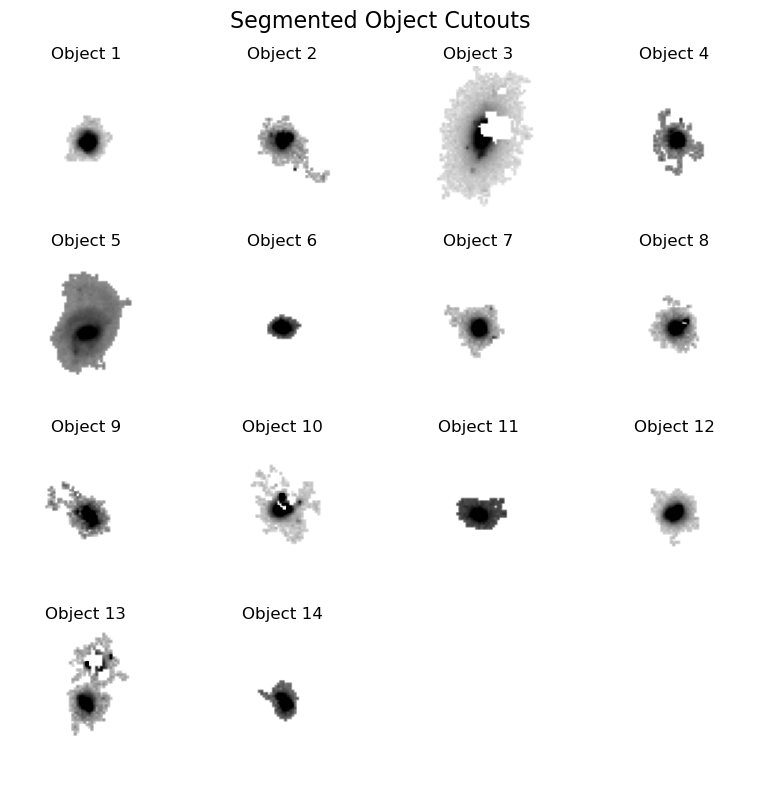

In [172]:
plot_cutouts(cutouts_g, num_cutouts=15)

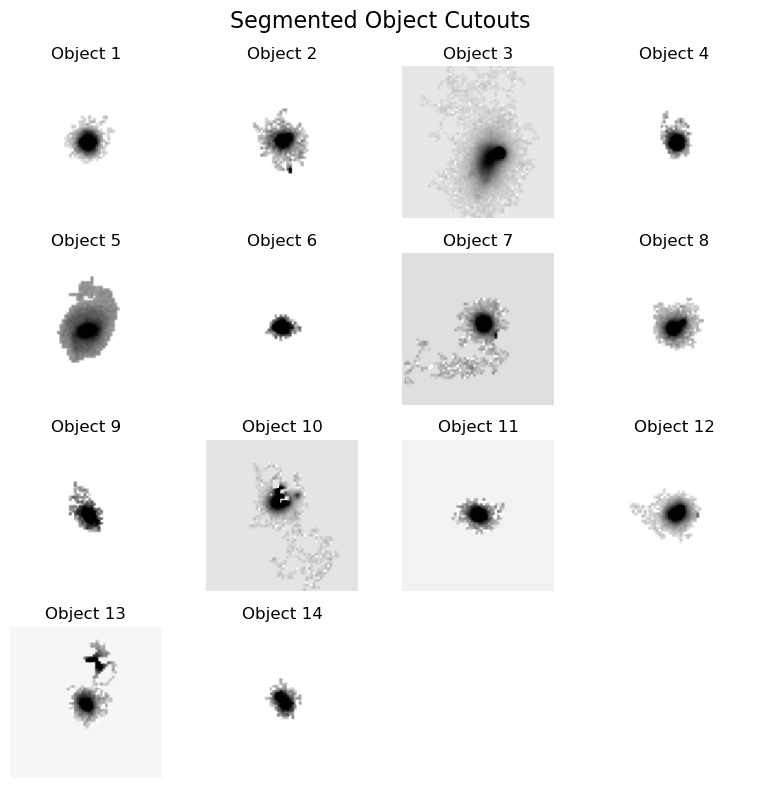

In [173]:
plot_cutouts(cutouts_i, num_cutouts=15)

In [222]:
# /arc/projects/unions/ssl/data/raw/tiles/dwarforge/239_291/cfis_lsb-r/CFIS_LSB.239.291.r_cutouts_single.h5
cutout_file_r = read_h5(os.path.join(data_dir, '239_291','cfis_lsb-r', 'CFIS_LSB.239.291.r_cutouts_single.h5'))
# cutout_file_g = read_h5(os.path.join(data_dir, '262_284','whigs-g', 'calexp-CFIS_262_284_cutouts.h5'))
# cutout_file_i = read_h5(os.path.join(data_dir, '262_284','ps-i', 'PSS.DR4.262.284.i_cutouts.h5'))

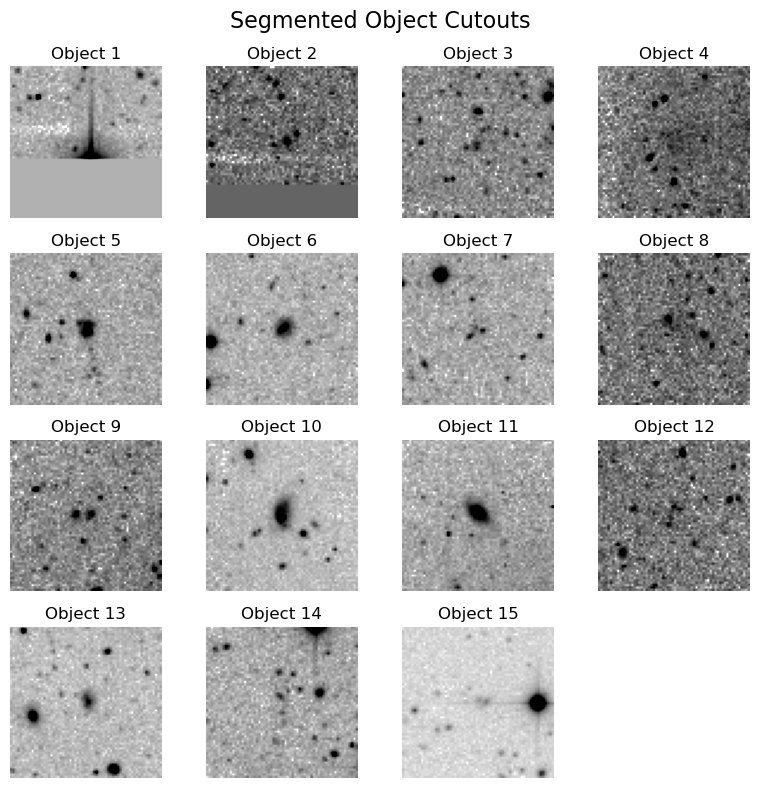

In [227]:
plot_cutouts(cutout_file_r['images'], num_cutouts=15)

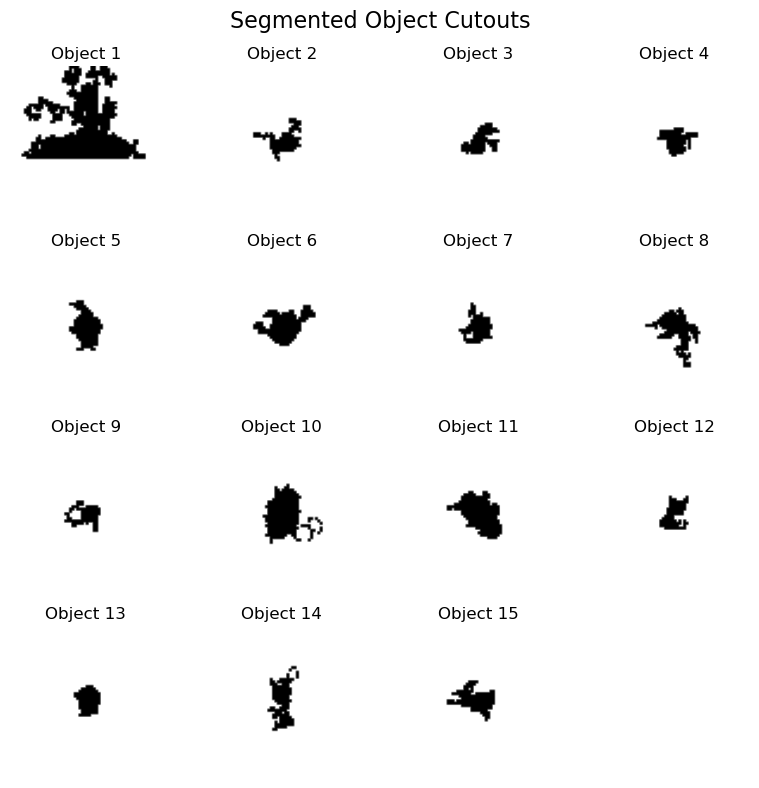

In [229]:
plot_cutouts(cutout_file_r['segmaps'], num_cutouts=15)

# Analysis

In [ ]:
tile_list = get_tile_list(dwarf_cat)

In [364]:
min_max_df

,r_10_arcsec,r_25_arcsec,re_arcsec,r_fwhm_arcsec,r_75_arcsec,r_90_arcsec,r_100_arcsec,mu_max,mu_median,mu_mean,axis_ratio,mag,mu,total_flux
min,0.000000,0.726135,1.623688,0.419235,2.178406,2.480225,2.843387,0.076542,0.007315,0.018447,0.121489,16.100834,22.524737,1.793653
max,8.096763,14.987267,25.965477,13.415505,41.291939,53.041038,77.789185,225.546780,0.790744,2.001968,0.984232,26.365654,29.526704,22891.094000


In [5]:
def check_param_filter(data, a, b, band, a1=None, b1=None):
    params_field = data.copy()
    df_dwarf = data.loc[data['lsb']==1].reset_index(drop=True)

    if band == 'cfis_lsb-r':
        conditions = {
                'mu': (22.0, None),  # (min, max), None means no limit
                're_arcsec': (1.6, 55.),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.353, 18.2),
                'r_25_arcsec': (0.4, 32.1),
                'r_75_arcsec': (2.16, 102.1),
                'r_90_arcsec': (2.5, 145.1),
                'r_100_arcsec': (2.8, 254.1),
                'r_fwhm_arcsec': (0.4, 13.8),
                'mu_median': (0.34, 28.7),
                'mu_mean': (0.4, 65.1),
                'mu_max': (2.0, 6255.0),
                'total_flux': (55, None),
                'mag': (12.17, 25.7),
                
            }

        # mag vs mu filter
        if a1 is not None and b1 is not None:
            params_field = params_field[(params_field['mu'] > (a * params_field['mag'] + b)) & (params_field['mu'] > (a1 * params_field['mag'] + b1))]
        else:
            params_field = params_field[params_field['mu'] > (a * params_field['mag'] + b)]
        params_field = params_field[(params_field['mu']/params_field['r_75_arcsec']) < np.maximum(1.5100*params_field['mag'] -24.6000, 3.0)]
        params_field = params_field[np.log(params_field['r_90_arcsec']/params_field['r_75_arcsec']) < (0.2950*np.log(params_field['r_100_arcsec']) -0.1300)]

    elif band == 'whigs-g':
        conditions = {
                'mu': (22.51, None),  # (min, max), None means no limit
                're_arcsec': (1.6, None),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.4, 8.1),
                'r_25_arcsec': (0.72, 15.0),
                'r_75_arcsec': (2.17, 42.0),
                'r_90_arcsec': (2.47, 54.0),
                'r_100_arcsec': (2.8, 79.0),
                'r_fwhm_arcsec': (0.417, 13.5),
                'mu_median': (0.0072, 0.8),
                'mu_mean': (0.017, 2.01),
                'mu_max': (0.066, 226.0),
                'total_flux': (1.77, None),
                'mag': (16.0, 26.5),
                
            }

        #mag vs mu filter
        if a1 is not None and b1 is not None:
            params_field = params_field[(params_field['mu'] > (a * params_field['mag'] + b)) & (params_field['mu'] > (a1 * params_field['mag'] + b1))]
        else:
            params_field = params_field[params_field['mu'] > (a * params_field['mag'] + b)]

        params_field = params_field[np.log(params_field['r_100_arcsec']/params_field['r_90_arcsec']) < (-1.2615*np.log(params_field['mag']) + 4.3000)]
        params_field = params_field[np.log(params_field['mag']/params_field['r_75_arcsec']) < np.maximum(6.4500*np.log(params_field['mag']) + -17.9000, 0.75)]

    elif band == 'ps-i':
        conditions = {
                'mu': (22.0, 29.5),  # (min, max), None means no limit
                're_arcsec': (1.6, 40.0),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.4, 14.95),
                'r_25_arcsec': (0.58, 25.5),
                'r_75_arcsec': (2.1, 58.0),
                'r_90_arcsec': (2.5, 77.0),
                'r_100_arcsec': (2.7, 117.0),
                'r_fwhm_arcsec': (0.4, 20.8),
                'mu_median': (0.445, 40.7),
                'mu_mean': (0.565, 100.8),
                'mu_max': (2.47, 4465.0),
                'total_flux': (66.0, None),
                'mag': (13.1, 26.0),
                
            }
        
        params_field = params_field[(params_field['r_90_arcsec']/params_field['r_75_arcsec']) < (0.0100*params_field['r_100_arcsec'] + 1.4000)]
        params_field = params_field[(params_field['r_100_arcsec']/params_field['r_90_arcsec']) < (-0.0850*params_field['mag'] + 3.3000)]
        params_field = params_field[(params_field['mag']/params_field['r_75_arcsec']) < np.maximum(1.4*params_field['mag'] - 23, 2.5)]
        params_field = params_field[(params_field['r_90_arcsec']/params_field['r_75_arcsec']) < (-0.0700*params_field['mag'] + 3.0000)]
        params_field = params_field[(params_field['r_75_arcsec']/params_field['r_25_arcsec']) < (0.2*params_field['mag'] + 2.3)]
        params_field = params_field[np.log(params_field['r_100_arcsec']/params_field['r_75_arcsec']) < (-2.7*np.log(params_field['mag']) + 9.05)]
        params_field = params_field[np.log(params_field['r_75_arcsec']/params_field['r_25_arcsec']) < (-0.9631*np.log(params_field['mag']) + 4.5500)]
    else:
        print(f'Conditions not implemented for band {band}.')
        return
    
    for column, (min_val, max_val) in conditions.items():
        if min_val is not None:
            params_field = params_field[params_field[column] > min_val]
        if max_val is not None:
            params_field = params_field[params_field[column] < max_val]
            
    # Remove streaks
    params_field = params_field[(params_field['axis_ratio'] >= 0.17) | (params_field['n_pix'] <= 1000)]
    
    # Remove previous index and reset
    params_field = params_field.reset_index(drop=True)
    
    print(f'Filtered out {len(data.loc[data["lsb"]==1])-len(params_field.loc[params_field["lsb"]==1])} real dwarfs from a total of {len(df_dwarf)}.')
    print(f'Filtered out {len(data.loc[data["lsb"]==0])-len(params_field.loc[params_field["lsb"]==0])} other objects from a total of {len(data.loc[data["lsb"]==0])}')

    return params_field

### r

In [5]:
# training_data_r = gather_training_data(data_dir, in_dict=band_dict, band='cfis_lsb-r', n_neighbors=20)
# training_data_r.to_csv(os.path.join(table_dir, 'training_data_r_20x_rf_v3.csv'), index=False)

  0%|          | 0/20490 [00:00<?, ?it/s]

In [6]:
training_data_file_r = 'training_data_r_20x_rf_v3.csv'
training_data_r = pd.read_csv(os.path.join(table_dir, training_data_file_r))

df_dwarf_r = training_data_r.loc[training_data_r['lsb'] == 1].reset_index(drop=True)
df_other_r = training_data_r.loc[training_data_r['lsb'] != 1].reset_index(drop=True)

In [90]:
min_max = df_dwarf_g.agg(['min', 'max'])
min_max_df = min_max[['r_10_arcsec', 'r_25_arcsec', 're_arcsec', 'r_fwhm_arcsec', 'r_75_arcsec', 'r_90_arcsec', 'r_100_arcsec', 'mu_max', 'mu_median', 'mu_mean', 'axis_ratio', 'mag', 'mu', 'total_flux']]

%matplotlib widget
plt.figure()
plt.hist(df_dwarf_r['r_10_arcsec'].values, bins=100)
plt.show()

### g

In [53]:
# bands_to_check = ['g']
# df_avail = check_availability(dwarf_cat_new, bands_to_check)
# tile_list_dwarfs = list(set(df_avail['tile'].values))
# tile_list = transform_list(tile_list_dwarfs)
# print(f'Using the new catalog, there are {len(df_avail)} known dwarfs in {bands_to_check} in the footprint.')

# training_data_g = gather_training_data(data_dir, in_dict=band_dict, band='whigs-g', n_neighbors=20, dwarf_tiles=tile_list)
# training_data_g.to_csv(os.path.join(table_dir, 'training_data_g_20x_rf_v3.csv'), index=False)

Using the new catalog, there are 2649 known dwarfs in ['g'] in the footprint.
Found 1511 detection catalogs from tiles with dwarfs.


100%|██████████| 1511/1511 [04:32<00:00,  5.55it/s]


In [7]:
training_data_file_g = 'training_data_g_20x_rf_v3.csv'
training_data_g = pd.read_csv(os.path.join(table_dir, training_data_file_g))

df_dwarf_g = training_data_g.loc[training_data_g['lsb'] == 1].reset_index(drop=True)
df_other_g = training_data_g.loc[training_data_g['lsb'] != 1].reset_index(drop=True)

In [192]:
(df_dwarf_g['r_25_arcsec'].values <= 0.4).sum()

0

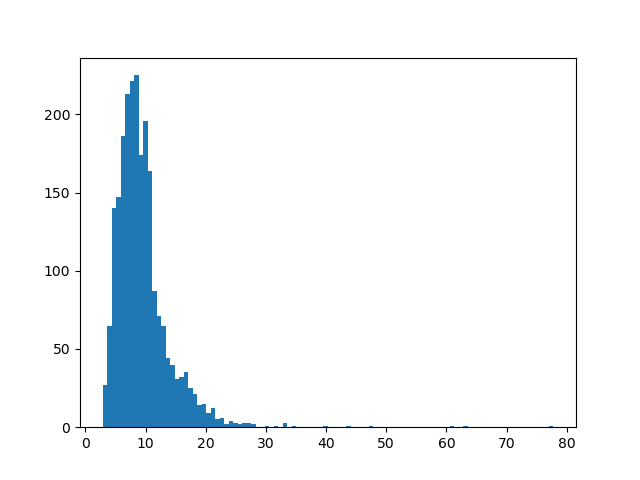

In [203]:
plt.figure()
plt.hist(df_dwarf_g['r_100_arcsec'].values, bins=100)
plt.show()

### i

In [10]:
bands_to_check = ['i']
df_avail = check_availability(dwarf_cat_new, bands_to_check)
tile_list_dwarfs = list(set(df_avail['tile'].values))
tile_list = transform_list(tile_list_dwarfs)
print(f'Using the new catalog, there are {len(df_avail)} known dwarfs in {bands_to_check} in the footprint.')

# training_data = gather_training_data(data_dir, in_dict=band_dict, band='ps-i', n_neighbors=20, dwarf_tiles=tile_list)
# training_data.to_csv(os.path.join(table_dir, 'training_data_i_20x_rf_v3.csv'), index=False)

Using the new catalog, there are 2856 known dwarfs in ['i'] in the footprint.


In [11]:
training_data_file_i = 'training_data_i_20x_rf_v3.csv'
training_data_i = pd.read_csv(os.path.join(table_dir, training_data_file_i))

df_dwarf_i = training_data_i.loc[training_data_i['lsb'] == 1].reset_index(drop=True)
df_other_i = training_data_i.loc[training_data_i['lsb'] != 1].reset_index(drop=True)

### Cross match and combine to master

In [12]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u
import re

def match_coordinates(reference_coords, target_coords, max_sep=15.0):
    """
    Match reference coordinates to target coordinates.

    Args:
        reference_coords (SkyCoord): Reference coordinates
        target_coords (SkyCoord): Target coordinates to match against
        max_sep (float): Maximum separation in arcseconds

    Returns:
        matched_ref_indices (array): Indices of matched reference coordinates
        matched_target_indices (array): Indices of matched target coordinates
    """
    idx, d2d, _ = reference_coords.match_to_catalog_3d(target_coords)
    mask = d2d < max_sep * u.arcsec
    return np.where(mask)[0], idx[mask]

def process_tile(tile_folder, bands, in_dict):
    all_data = {band: None for band in bands}
    
    for band in bands:
        zfill = in_dict[band]['zfill']
        file_prefix = in_dict[band]['name']
        delimiter = in_dict[band]['delimiter']
        suffix = in_dict[band]['suffix']
        file_pattern = f"{file_prefix}{delimiter}*{suffix}_rebin_star_mask*_det_params.parquet"
        file_path = os.path.join(tile_folder, band, file_pattern)
        matching_files = glob(file_path)
        
        if matching_files:
            df = pd.read_parquet(matching_files[0])
            df.columns = [f"{col}_{band}" if col not in ['ID_known', 'ra', 'dec', 'lsb'] else col for col in df.columns]
            all_data[band] = df
        else:
            print(f"No matching file found for band {band} in folder {tile_folder}")
            return None
    
    # Identify dwarf galaxies present in all bands with lsb == 1
    dwarf_ids = set(all_data[bands[0]][(all_data[bands[0]]['lsb'] == 1) & (all_data[bands[0]]['ID_known'].notna())]['ID_known'])
    for band in bands[1:]:
        dwarf_ids &= set(all_data[band][(all_data[band]['lsb'] == 1) & (all_data[band]['ID_known'].notna())]['ID_known'])
    
    # Get the full data for matched dwarfs
    final_dwarfs = all_data[bands[0]][all_data[bands[0]]['ID_known'].isin(dwarf_ids)]
    for band in bands[1:]:
        band_data = all_data[band][all_data[band]['ID_known'].isin(dwarf_ids)]
        final_dwarfs = pd.merge(final_dwarfs, band_data, on=['ID_known', 'ra', 'dec', 'lsb'], suffixes=('', f'_{band}'))
    
    # Process non-dwarf objects
    non_dwarf_data = {band: all_data[band][~all_data[band]['ID_known'].isin(dwarf_ids)] for band in bands}
    
    # Match non-dwarf objects using coordinates
    r_band = bands[0]  # Assuming the first band is r-band
    r_band_coords = SkyCoord(non_dwarf_data[r_band]['ra'], non_dwarf_data[r_band]['dec'], unit=u.deg)
    
    matched_indices = {r_band: np.arange(len(non_dwarf_data[r_band]))}
    for band in bands[1:]:
        target_coords = SkyCoord(non_dwarf_data[band]['ra'], non_dwarf_data[band]['dec'], unit=u.deg)
        matched_r_indices, matched_target_indices = match_coordinates(r_band_coords, target_coords)
        matched_indices[band] = (matched_r_indices, matched_target_indices)
    
    # Find common matches across all bands for non-dwarf objects
    common_r_indices = matched_indices[r_band]
    for band in bands[1:]:
        common_r_indices = np.intersect1d(common_r_indices, matched_indices[band][0])
    
    # Update matched indices for all bands based on common matches
    final_indices = {r_band: common_r_indices}
    for band in bands[1:]:
        mask = np.isin(matched_indices[band][0], common_r_indices)
        final_indices[band] = matched_indices[band][1][mask]
    
    # Create the final dataframe with matched non-dwarf objects
    final_non_dwarfs = non_dwarf_data[r_band].iloc[final_indices[r_band]].reset_index(drop=True)
    for band in bands[1:]:
        band_data = non_dwarf_data[band].iloc[final_indices[band]].reset_index(drop=True)
        final_non_dwarfs = pd.concat([final_non_dwarfs, band_data.add_suffix(f'_{band}')], axis=1)
    
    # Combine matched dwarf and non-dwarf objects
    final_data = pd.concat([final_dwarfs, final_non_dwarfs], ignore_index=True)
    
    # Remove duplicate columns (ra, dec, lsb from other bands)
    columns_to_drop = [col for col in final_data.columns if col.startswith(('ra_', 'dec_', 'lsb_'))]
    final_data = final_data.drop(columns=columns_to_drop)
    
    # Add tile information
    final_data['tile'] = os.path.basename(tile_folder)
    
    return final_data

def gather_photometric_data(parent_folder, bands, in_dict, output_file, tile_folders=None):
    all_data = []
    if tile_folders is not None:
        tile_folders = transform_list(tile_folders)
    else:
        tile_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]
    
    for tile_folder in tqdm(tile_folders, desc="Processing tiles"):
        tile_path = os.path.join(parent_folder, tile_folder)
        result = process_tile(tile_path, bands, in_dict)
        return result
        if result is not None:
            all_data.append(result)
            print(f"Processed data for tile {tile_folder}")
        else:
            print(f"Skipped tile {tile_folder} due to missing data")
    
    # Combine all processed data into a single DataFrame
    final_data = pd.concat(all_data, ignore_index=True)
    
    # Save the final DataFrame to a single parquet file
    final_data.to_parquet(output_file)
    print(f"All data processed and saved to {output_file}")

In [10]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u

def match_coordinates(reference_coords, target_coords, max_sep=15.0):
    """
    Match reference coordinates to target coordinates.

    Args:
        reference_coords (SkyCoord): Reference coordinates
        target_coords (SkyCoord): Target coordinates to match against
        max_sep (float): Maximum separation in arcseconds

    Returns:
        matched_ref_indices (array): Indices of matched reference coordinates
        matched_target_indices (array): Indices of matched target coordinates
    """
    idx, d2d, _ = reference_coords.match_to_catalog_3d(target_coords)
    mask = d2d < max_sep * u.arcsec
    return np.where(mask)[0], idx[mask]

# def process_tile(tile_folder, bands, in_dict):
#     all_data = {band: None for band in bands}
#     tilename = os.path.basename(os.path.normpath(tile_folder))
#     print(f"Processing tile: {tilename}")
    
#     # Read data for all bands
#     for band in bands:
#         zfill = in_dict[band]['zfill']
#         file_prefix = in_dict[band]['name']
#         delimiter = in_dict[band]['delimiter']
#         suffix = in_dict[band]['suffix']
#         file_pattern = f"{file_prefix}{delimiter}*{suffix}_rebin_star_mask*_det_params.parquet"
#         file_path = os.path.join(tile_folder, band, file_pattern)
#         matching_files = glob(file_path)
        
#         if matching_files:
#             df = pd.read_parquet(matching_files[0])
#             print(f"Tile {tilename}, Band {band}: Initial objects = {len(df)}")
#             if df.empty:
#                 print(f'Tile {tilename}: dataframe empty for band {band}.')
#                 return None
#             df['ID_known'] = df['ID_known'].fillna('').astype(str)
#             if band != bands[0]:  # not r-band
#                 df = df.drop(columns=['ra', 'dec'])  # We'll use r-band ra, dec
#             df.columns = [f"{col}_{band}" if col not in ['ID_known', 'ra', 'dec', 'lsb'] else col for col in df.columns]
#             all_data[band] = df
#         else:
#             print(f"No matching file found for band {band} in folder {tile_folder}")
#             return None
    
#     # Identify dwarf galaxies present in all bands with lsb == 1 and non-empty ID_known
#     dwarf_ids = set(all_data[bands[0]][(all_data[bands[0]]['lsb'] == 1) & (all_data[bands[0]]['ID_known'] != '')]['ID_known'])
#     for band in bands[1:]:
#         band_dwarf_ids = set(all_data[band][(all_data[band]['lsb'] == 1) & (all_data[band]['ID_known'] != '')]['ID_known'])
#         dwarf_ids &= band_dwarf_ids
    
#     print(f'Tile: {tilename}, number of common dwarf ids: {len(dwarf_ids)}')
    
#     # Process dwarf galaxies
#     final_dwarfs = all_data[bands[0]][all_data[bands[0]]['ID_known'].isin(dwarf_ids)]
#     for band in bands[1:]:
#         band_data = all_data[band][all_data[band]['ID_known'].isin(dwarf_ids)]
#         final_dwarfs = pd.merge(final_dwarfs, band_data, on='ID_known', suffixes=('', f'_{band}'))
    
#     print(f"Tile {tilename}: Matched dwarfs = {len(final_dwarfs)}")
    
#     # Process non-dwarf objects
#     non_dwarf_data = {band: all_data[band][~all_data[band]['ID_known'].isin(dwarf_ids)] for band in bands}
#     for band in bands:
#         print(f"Tile {tilename}, Band {band}: Non-dwarf objects = {len(non_dwarf_data[band])}")
    
#     # Match non-dwarf objects using coordinates
#     r_band = bands[0]  # Assuming the first band is r-band
#     r_band_coords = SkyCoord(non_dwarf_data[r_band][f'ra_{band}'], non_dwarf_data[r_band][f'dec_{band}'], unit=u.deg)
    
#     matched_indices = {r_band: np.arange(len(non_dwarf_data[r_band]))}
#     for band in bands[1:]:
#         target_coords = SkyCoord(non_dwarf_data[band][f'ra_{band}'], non_dwarf_data[band][f'dec_{band}'], unit=u.deg)
#         matched_r_indices, matched_target_indices = match_coordinates(r_band_coords, target_coords)
#         matched_indices[band] = (matched_r_indices, matched_target_indices)
#         print(f"Tile {tilename}, Band {band}: Matched non-dwarf objects = {len(matched_r_indices)}")
    
#     # Find common matches across all bands for non-dwarf objects
#     common_r_indices = matched_indices[r_band]
#     for band in bands[1:]:
#         common_r_indices = np.intersect1d(common_r_indices, matched_indices[band][0])
    
#     print(f"Tile {tilename}: Common non-dwarf matches across all bands = {len(common_r_indices)}")
    
#     # Create the final dataframe with matched non-dwarf objects
#     final_non_dwarfs = non_dwarf_data[r_band].iloc[common_r_indices].reset_index(drop=True)
#     for band in bands[1:]:
#         band_indices = matched_indices[band][1][np.isin(matched_indices[band][0], common_r_indices)]
#         band_data = non_dwarf_data[band].iloc[band_indices].reset_index(drop=True)
#         final_non_dwarfs = pd.concat([final_non_dwarfs, band_data.add_suffix(f'_{band}')], axis=1)
    
#     print(f"Tile {tilename}: Final matched non-dwarfs = {len(final_non_dwarfs)}")
    
#     # Combine matched dwarf and non-dwarf objects
#     final_data = pd.concat([final_dwarfs, final_non_dwarfs], ignore_index=True)
    
#     # Add tile information
#     final_data['tile'] = tilename
    
#     print(f"Tile {tilename}: Total objects = {len(final_data)}, Dwarfs = {len(final_dwarfs)}, Non-dwarfs = {len(final_non_dwarfs)}")
    
#     return final_data

def process_tile(tile_folder, bands, in_dict):
    all_data = {band: None for band in bands}
    tilename = os.path.basename(os.path.normpath(tile_folder))
    print(f"Processing tile: {tilename}")
    
    # Read data for all bands
    for band in bands:
        zfill = in_dict[band]['zfill']
        file_prefix = in_dict[band]['name']
        delimiter = in_dict[band]['delimiter']
        suffix = in_dict[band]['suffix']
        file_pattern = f"{file_prefix}{delimiter}*{suffix}_rebin_star_mask*_det_params.parquet"
        file_path = os.path.join(tile_folder, band, file_pattern)
        matching_files = glob(file_path)
        
        if matching_files:
            df = pd.read_parquet(matching_files[0])
            print(f"Tile {tilename}, Band {band}: Initial objects = {len(df)}")
            if df.empty:
                print(f'Tile {tilename}: dataframe empty for band {band}.')
                return None
            df['ID_known'] = df['ID_known'].fillna('').astype(str)
            df.columns = [f"{col}_{band}" if col not in ['ID_known'] else col for col in df.columns]
            all_data[band] = df
        else:
            print(f"No matching file found for band {band} in folder {tile_folder}")
            return None
    
    # Identify dwarf galaxies present in all bands with lsb == 1 and non-empty ID_known
    dwarf_ids = set(all_data[bands[0]][(all_data[bands[0]][f'lsb_{bands[0]}'] == 1) & (all_data[bands[0]]['ID_known'] != '')]['ID_known'])
    for band in bands[1:]:
        band_dwarf_ids = set(all_data[band][(all_data[band][f'lsb_{band}'] == 1) & (all_data[band]['ID_known'] != '')]['ID_known'])
        dwarf_ids &= band_dwarf_ids
    
    print(f'Tile: {tilename}, number of common dwarf ids: {len(dwarf_ids)}')
    
    # Process dwarf galaxies
    final_dwarfs = all_data[bands[0]][all_data[bands[0]]['ID_known'].isin(dwarf_ids)]
    for band in bands[1:]:
        band_data = all_data[band][all_data[band]['ID_known'].isin(dwarf_ids)]
        final_dwarfs = pd.merge(final_dwarfs, band_data, on='ID_known', suffixes=('', f'_{band}'))
    
    print(f"Tile {tilename}: Matched dwarfs = {len(final_dwarfs)}")
    
    # Process non-dwarf objects
    non_dwarf_data = {band: all_data[band][~all_data[band]['ID_known'].isin(dwarf_ids)] for band in bands}
    for band in bands:
        print(f"Tile {tilename}, Band {band}: Non-dwarf objects = {len(non_dwarf_data[band])}")
    
    # Match non-dwarf objects using coordinates
    r_band = bands[0]  # Assuming the first band is r-band
    r_band_coords = SkyCoord(non_dwarf_data[r_band][f'ra_{r_band}'], non_dwarf_data[r_band][f'dec_{r_band}'], unit=u.deg)
    
    matched_indices = {r_band: np.arange(len(non_dwarf_data[r_band]))}
    for band in bands[1:]:
        target_coords = SkyCoord(non_dwarf_data[band][f'ra_{band}'], non_dwarf_data[band][f'dec_{band}'], unit=u.deg)
        matched_r_indices, matched_target_indices = match_coordinates(r_band_coords, target_coords)
        matched_indices[band] = (matched_r_indices, matched_target_indices)
        print(f"Tile {tilename}, Band {band}: Matched non-dwarf objects = {len(matched_r_indices)}")
    
    # Find common matches across all bands for non-dwarf objects
    common_r_indices = matched_indices[r_band]
    for band in bands[1:]:
        common_r_indices = np.intersect1d(common_r_indices, matched_indices[band][0])
    
    print(f"Tile {tilename}: Common non-dwarf matches across all bands = {len(common_r_indices)}")
    
    # Create the final dataframe with matched non-dwarf objects
    final_non_dwarfs = non_dwarf_data[r_band].iloc[common_r_indices].reset_index(drop=True)
    for band in bands[1:]:
        band_indices = matched_indices[band][1][np.isin(matched_indices[band][0], common_r_indices)]
        band_data = non_dwarf_data[band].iloc[band_indices].reset_index(drop=True)
        final_non_dwarfs = pd.merge(final_non_dwarfs, band_data, left_index=True, right_index=True, suffixes=('', f'_{band}'))
    
    print(f"Tile {tilename}: Final matched non-dwarfs = {len(final_non_dwarfs)}")
    
    # Combine matched dwarf and non-dwarf objects
    final_data = pd.concat([final_dwarfs, final_non_dwarfs], ignore_index=True)
    
    # Add tile information
    final_data['tile'] = tilename
    
    print(f"Tile {tilename}: Total objects = {len(final_data)}, Dwarfs = {len(final_dwarfs)}, Non-dwarfs = {len(final_non_dwarfs)}")
    
    return final_data

def gather_photometric_data(parent_folder, bands, in_dict, output_file, tile_folders=None):
    all_data = []
    if tile_folders is not None:
        tile_folders = transform_list(tile_folders)
    else:
        tile_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]
    
    for tile_folder in tqdm(tile_folders, desc="Processing tiles"):
        tile_path = os.path.join(parent_folder, tile_folder)
        result = process_tile(tile_path, bands, in_dict)
        if result is not None:
            all_data.append(result)
            # print(f"Processed data for tile {tile_folder}")
        else:
            print(f"Skipped tile {tile_folder} due to missing data")
    
    # Combine all processed data into a single DataFrame
    final_data = pd.concat(all_data, ignore_index=True)
    
    # Save the final DataFrame to a single parquet file
    final_data.to_parquet(output_file)
    print(f"All data processed and saved to {output_file}")

In [267]:
bands = ['cfis_lsb-r', 'whigs-g', 'ps-i']
output_file = 'umap_data_master1.parquet'
test_result = gather_photometric_data(data_dir, bands, band_dict, output_file, tile_folders=tile_list_dwarfs)

Processing tiles:   0%|          | 3/1333 [00:00<01:04, 20.60it/s]

Processing tile: 285_267
Tile 285_267, Band cfis_lsb-r: Initial objects = 82
Tile 285_267, Band whigs-g: Initial objects = 470
Tile 285_267, Band ps-i: Initial objects = 255
Tile: 285_267, number of common dwarf ids: 1
Tile 285_267: Matched dwarfs = 1
Tile 285_267, Band cfis_lsb-r: Non-dwarf objects = 81
Tile 285_267, Band whigs-g: Non-dwarf objects = 469
Tile 285_267, Band ps-i: Non-dwarf objects = 254
Tile 285_267, Band whigs-g: Matched non-dwarf objects = 61
Tile 285_267, Band ps-i: Matched non-dwarf objects = 39
Tile 285_267: Common non-dwarf matches across all bands = 36
Tile 285_267: Final matched non-dwarfs = 36
Tile 285_267: Total objects = 37, Dwarfs = 1, Non-dwarfs = 36
Processing tile: 218_248
Tile 218_248, Band cfis_lsb-r: Initial objects = 50
Tile 218_248, Band whigs-g: Initial objects = 65
Tile 218_248, Band ps-i: Initial objects = 302
Tile: 218_248, number of common dwarf ids: 0
Tile 218_248: Matched dwarfs = 0
Tile 218_248, Band cfis_lsb-r: Non-dwarf objects = 50
Tile 2

Processing tiles:   0%|          | 6/1333 [00:00<01:00, 21.96it/s]

Tile 350_262, Band whigs-g: Initial objects = 162
Tile 350_262, Band ps-i: Initial objects = 251
Tile: 350_262, number of common dwarf ids: 1
Tile 350_262: Matched dwarfs = 1
Tile 350_262, Band cfis_lsb-r: Non-dwarf objects = 224
Tile 350_262, Band whigs-g: Non-dwarf objects = 161
Tile 350_262, Band ps-i: Non-dwarf objects = 250
Tile 350_262, Band whigs-g: Matched non-dwarf objects = 62
Tile 350_262, Band ps-i: Matched non-dwarf objects = 39
Tile 350_262: Common non-dwarf matches across all bands = 26
Tile 350_262: Final matched non-dwarfs = 26
Tile 350_262: Total objects = 27, Dwarfs = 1, Non-dwarfs = 26
Processing tile: 363_251
Tile 363_251, Band cfis_lsb-r: Initial objects = 59
Tile 363_251, Band whigs-g: Initial objects = 134
Tile 363_251, Band ps-i: Initial objects = 283
Tile: 363_251, number of common dwarf ids: 0
Tile 363_251: Matched dwarfs = 0
Tile 363_251, Band cfis_lsb-r: Non-dwarf objects = 59
Tile 363_251, Band whigs-g: Non-dwarf objects = 134
Tile 363_251, Band ps-i: Non-

Processing tiles:   1%|          | 12/1333 [00:00<00:59, 22.39it/s]

Tile 299_243: Final matched non-dwarfs = 34
Tile 299_243: Total objects = 35, Dwarfs = 1, Non-dwarfs = 34
Processing tile: 336_254
Tile 336_254, Band cfis_lsb-r: Initial objects = 46
Tile 336_254, Band whigs-g: Initial objects = 129
Tile 336_254, Band ps-i: Initial objects = 330
Tile: 336_254, number of common dwarf ids: 1
Tile 336_254: Matched dwarfs = 1
Tile 336_254, Band cfis_lsb-r: Non-dwarf objects = 45
Tile 336_254, Band whigs-g: Non-dwarf objects = 128
Tile 336_254, Band ps-i: Non-dwarf objects = 329
Tile 336_254, Band whigs-g: Matched non-dwarf objects = 22
Tile 336_254, Band ps-i: Matched non-dwarf objects = 15
Tile 336_254: Common non-dwarf matches across all bands = 13
Tile 336_254: Final matched non-dwarfs = 13
Tile 336_254: Total objects = 14, Dwarfs = 1, Non-dwarfs = 13
Processing tile: 159_321
Tile 159_321, Band cfis_lsb-r: Initial objects = 102
Tile 159_321, Band whigs-g: Initial objects = 336
Tile 159_321, Band ps-i: Initial objects = 370
Tile: 159_321, number of commo

Processing tiles:   1%|▏         | 18/1333 [00:00<00:55, 23.50it/s]

Tile 156_298, Band ps-i: Matched non-dwarf objects = 12
Tile 156_298: Common non-dwarf matches across all bands = 9
Tile 156_298: Final matched non-dwarfs = 9
Tile 156_298: Total objects = 10, Dwarfs = 1, Non-dwarfs = 9
Processing tile: 303_246
Tile 303_246, Band cfis_lsb-r: Initial objects = 146
Tile 303_246, Band whigs-g: Initial objects = 213
Tile 303_246, Band ps-i: Initial objects = 164
Tile: 303_246, number of common dwarf ids: 0
Tile 303_246: Matched dwarfs = 0
Tile 303_246, Band cfis_lsb-r: Non-dwarf objects = 146
Tile 303_246, Band whigs-g: Non-dwarf objects = 213
Tile 303_246, Band ps-i: Non-dwarf objects = 164
Tile 303_246, Band whigs-g: Matched non-dwarf objects = 67
Tile 303_246, Band ps-i: Matched non-dwarf objects = 26
Tile 303_246: Common non-dwarf matches across all bands = 20
Tile 303_246: Final matched non-dwarfs = 20
Tile 303_246: Total objects = 20, Dwarfs = 0, Non-dwarfs = 20
Processing tile: 267_254
Tile 267_254, Band cfis_lsb-r: Initial objects = 119
Tile 267_25

Processing tiles:   2%|▏         | 21/1333 [00:00<00:57, 22.85it/s]

Tile 178_307, Band whigs-g: Matched non-dwarf objects = 51
Tile 178_307, Band ps-i: Matched non-dwarf objects = 67
Tile 178_307: Common non-dwarf matches across all bands = 45
Tile 178_307: Final matched non-dwarfs = 45
Tile 178_307: Total objects = 46, Dwarfs = 1, Non-dwarfs = 45
Processing tile: 338_243
Tile 338_243, Band cfis_lsb-r: Initial objects = 134
Tile 338_243, Band whigs-g: Initial objects = 134
Tile 338_243, Band ps-i: Initial objects = 415
Tile: 338_243, number of common dwarf ids: 2
Tile 338_243: Matched dwarfs = 2
Tile 338_243, Band cfis_lsb-r: Non-dwarf objects = 132
Tile 338_243, Band whigs-g: Non-dwarf objects = 132
Tile 338_243, Band ps-i: Non-dwarf objects = 413
Tile 338_243, Band whigs-g: Matched non-dwarf objects = 68
Tile 338_243, Band ps-i: Matched non-dwarf objects = 57
Tile 338_243: Common non-dwarf matches across all bands = 38
Tile 338_243: Final matched non-dwarfs = 38
Tile 338_243: Total objects = 40, Dwarfs = 2, Non-dwarfs = 38
Processing tile: 309_244
Ti

Processing tiles:   2%|▏         | 27/1333 [00:01<00:54, 24.03it/s]

Tile 321_242, Band whigs-g: Matched non-dwarf objects = 34
Tile 321_242, Band ps-i: Matched non-dwarf objects = 27
Tile 321_242: Common non-dwarf matches across all bands = 21
Tile 321_242: Final matched non-dwarfs = 21
Tile 321_242: Total objects = 21, Dwarfs = 0, Non-dwarfs = 21
Processing tile: 331_240
Tile 331_240, Band cfis_lsb-r: Initial objects = 86
Tile 331_240, Band whigs-g: Initial objects = 39
Tile 331_240, Band ps-i: Initial objects = 133
Tile: 331_240, number of common dwarf ids: 1
Tile 331_240: Matched dwarfs = 1
Tile 331_240, Band cfis_lsb-r: Non-dwarf objects = 85
Tile 331_240, Band whigs-g: Non-dwarf objects = 38
Tile 331_240, Band ps-i: Non-dwarf objects = 132
Tile 331_240, Band whigs-g: Matched non-dwarf objects = 15
Tile 331_240, Band ps-i: Matched non-dwarf objects = 13
Tile 331_240: Common non-dwarf matches across all bands = 5
Tile 331_240: Final matched non-dwarfs = 5
Tile 331_240: Total objects = 6, Dwarfs = 1, Non-dwarfs = 5
Processing tile: 135_295
Tile 135_2

Processing tiles:   2%|▏         | 33/1333 [00:01<00:54, 23.94it/s]

Tile 321_245, Band ps-i: Matched non-dwarf objects = 12
Tile 321_245: Common non-dwarf matches across all bands = 10
Tile 321_245: Final matched non-dwarfs = 10
Tile 321_245: Total objects = 11, Dwarfs = 1, Non-dwarfs = 10
Processing tile: 205_265
Tile 205_265, Band cfis_lsb-r: Initial objects = 123
Tile 205_265, Band whigs-g: Initial objects = 120
Tile 205_265, Band ps-i: Initial objects = 371
Tile: 205_265, number of common dwarf ids: 1
Tile 205_265: Matched dwarfs = 1
Tile 205_265, Band cfis_lsb-r: Non-dwarf objects = 122
Tile 205_265, Band whigs-g: Non-dwarf objects = 119
Tile 205_265, Band ps-i: Non-dwarf objects = 370
Tile 205_265, Band whigs-g: Matched non-dwarf objects = 41
Tile 205_265, Band ps-i: Matched non-dwarf objects = 46
Tile 205_265: Common non-dwarf matches across all bands = 33
Tile 205_265: Final matched non-dwarfs = 33
Tile 205_265: Total objects = 34, Dwarfs = 1, Non-dwarfs = 33
Processing tile: 141_289
Tile 141_289, Band cfis_lsb-r: Initial objects = 88
Tile 141_

Processing tiles:   3%|▎         | 36/1333 [00:01<00:55, 23.17it/s]

Tile 094_330, Band ps-i: Matched non-dwarf objects = 32
Tile 094_330: Common non-dwarf matches across all bands = 23
Tile 094_330: Final matched non-dwarfs = 23
Tile 094_330: Total objects = 25, Dwarfs = 2, Non-dwarfs = 23
Processing tile: 155_309
Tile 155_309, Band cfis_lsb-r: Initial objects = 69
Tile 155_309, Band whigs-g: Initial objects = 96
Tile 155_309, Band ps-i: Initial objects = 266
Tile: 155_309, number of common dwarf ids: 0
Tile 155_309: Matched dwarfs = 0
Tile 155_309, Band cfis_lsb-r: Non-dwarf objects = 69
Tile 155_309, Band whigs-g: Non-dwarf objects = 96
Tile 155_309, Band ps-i: Non-dwarf objects = 266
Tile 155_309, Band whigs-g: Matched non-dwarf objects = 36
Tile 155_309, Band ps-i: Matched non-dwarf objects = 30
Tile 155_309: Common non-dwarf matches across all bands = 22
Tile 155_309: Final matched non-dwarfs = 22
Tile 155_309: Total objects = 22, Dwarfs = 0, Non-dwarfs = 22
Processing tile: 248_301
Tile 248_301, Band cfis_lsb-r: Initial objects = 359
Tile 248_301

Processing tiles:   3%|▎         | 42/1333 [00:01<00:55, 23.35it/s]

Tile 300_245: Matched dwarfs = 0
Tile 300_245, Band cfis_lsb-r: Non-dwarf objects = 125
Tile 300_245, Band whigs-g: Non-dwarf objects = 139
Tile 300_245, Band ps-i: Non-dwarf objects = 527
Tile 300_245, Band whigs-g: Matched non-dwarf objects = 50
Tile 300_245, Band ps-i: Matched non-dwarf objects = 62
Tile 300_245: Common non-dwarf matches across all bands = 34
Tile 300_245: Final matched non-dwarfs = 34
Tile 300_245: Total objects = 34, Dwarfs = 0, Non-dwarfs = 34
Processing tile: 325_268
Tile 325_268, Band cfis_lsb-r: Initial objects = 72
Tile 325_268, Band whigs-g: Initial objects = 166
Tile 325_268, Band ps-i: Initial objects = 371
Tile: 325_268, number of common dwarf ids: 1
Tile 325_268: Matched dwarfs = 1
Tile 325_268, Band cfis_lsb-r: Non-dwarf objects = 71
Tile 325_268, Band whigs-g: Non-dwarf objects = 165
Tile 325_268, Band ps-i: Non-dwarf objects = 370
Tile 325_268, Band whigs-g: Matched non-dwarf objects = 36
Tile 325_268, Band ps-i: Matched non-dwarf objects = 32
Tile 32

Processing tiles:   4%|▎         | 49/1333 [00:02<00:50, 25.55it/s]

Tile 261_240, Band whigs-g: Initial objects = 62
Tile 261_240, Band ps-i: Initial objects = 308
Tile: 261_240, number of common dwarf ids: 1
Tile 261_240: Matched dwarfs = 1
Tile 261_240, Band cfis_lsb-r: Non-dwarf objects = 149
Tile 261_240, Band whigs-g: Non-dwarf objects = 61
Tile 261_240, Band ps-i: Non-dwarf objects = 307
Tile 261_240, Band whigs-g: Matched non-dwarf objects = 25
Tile 261_240, Band ps-i: Matched non-dwarf objects = 42
Tile 261_240: Common non-dwarf matches across all bands = 18
Tile 261_240: Final matched non-dwarfs = 18
Tile 261_240: Total objects = 19, Dwarfs = 1, Non-dwarfs = 18
Processing tile: 229_291
Tile 229_291, Band cfis_lsb-r: Initial objects = 166
No matching file found for band whigs-g in folder /arc/projects/unions/ssl/data/raw/tiles/dwarforge/229_291
Skipped tile 229_291 due to missing data
Processing tile: 088_326
Tile 088_326, Band cfis_lsb-r: Initial objects = 206
Tile 088_326, Band whigs-g: Initial objects = 421
Tile 088_326, Band ps-i: Initial o

Processing tiles:   4%|▍         | 52/1333 [00:02<00:51, 24.91it/s]

Tile 151_298, Band cfis_lsb-r: Initial objects = 96
Tile 151_298, Band whigs-g: Initial objects = 131
Tile 151_298, Band ps-i: Initial objects = 129
Tile: 151_298, number of common dwarf ids: 0
Tile 151_298: Matched dwarfs = 0
Tile 151_298, Band cfis_lsb-r: Non-dwarf objects = 96
Tile 151_298, Band whigs-g: Non-dwarf objects = 131
Tile 151_298, Band ps-i: Non-dwarf objects = 129
Tile 151_298, Band whigs-g: Matched non-dwarf objects = 41
Tile 151_298, Band ps-i: Matched non-dwarf objects = 12
Tile 151_298: Common non-dwarf matches across all bands = 9
Tile 151_298: Final matched non-dwarfs = 9
Tile 151_298: Total objects = 9, Dwarfs = 0, Non-dwarfs = 9
Processing tile: 214_299
Tile 214_299, Band cfis_lsb-r: Initial objects = 117
Tile 214_299, Band whigs-g: Initial objects = 161
Tile 214_299, Band ps-i: Initial objects = 435
Tile: 214_299, number of common dwarf ids: 1
Tile 214_299: Matched dwarfs = 1
Tile 214_299, Band cfis_lsb-r: Non-dwarf objects = 116
Tile 214_299, Band whigs-g: Non-

Processing tiles:   4%|▍         | 58/1333 [00:02<00:52, 24.14it/s]

Tile 259_255, Band ps-i: Matched non-dwarf objects = 61
Tile 259_255: Common non-dwarf matches across all bands = 40
Tile 259_255: Final matched non-dwarfs = 40
Tile 259_255: Total objects = 40, Dwarfs = 0, Non-dwarfs = 40
Processing tile: 269_257
Tile 269_257, Band cfis_lsb-r: Initial objects = 126
Tile 269_257, Band whigs-g: Initial objects = 134
Tile 269_257, Band ps-i: Initial objects = 410
Tile: 269_257, number of common dwarf ids: 1
Tile 269_257: Matched dwarfs = 1
Tile 269_257, Band cfis_lsb-r: Non-dwarf objects = 125
Tile 269_257, Band whigs-g: Non-dwarf objects = 133
Tile 269_257, Band ps-i: Non-dwarf objects = 409
Tile 269_257, Band whigs-g: Matched non-dwarf objects = 44
Tile 269_257, Band ps-i: Matched non-dwarf objects = 58
Tile 269_257: Common non-dwarf matches across all bands = 31
Tile 269_257: Final matched non-dwarfs = 31
Tile 269_257: Total objects = 32, Dwarfs = 1, Non-dwarfs = 31
Processing tile: 237_292
Tile 237_292, Band cfis_lsb-r: Initial objects = 78
Tile 237_

Processing tiles:   5%|▍         | 61/1333 [00:02<00:54, 23.47it/s]


Tile 075_328: Final matched non-dwarfs = 30
Tile 075_328: Total objects = 30, Dwarfs = 0, Non-dwarfs = 30
Processing tile: 273_281
Tile 273_281, Band cfis_lsb-r: Initial objects = 79
Tile 273_281, Band whigs-g: Initial objects = 173
Tile 273_281, Band ps-i: Initial objects = 330
Tile: 273_281, number of common dwarf ids: 0
Tile 273_281: Matched dwarfs = 0
Tile 273_281, Band cfis_lsb-r: Non-dwarf objects = 79
Tile 273_281, Band whigs-g: Non-dwarf objects = 173
Tile 273_281, Band ps-i: Non-dwarf objects = 330
Tile 273_281, Band whigs-g: Matched non-dwarf objects = 43
Tile 273_281, Band ps-i: Matched non-dwarf objects = 37
Tile 273_281: Common non-dwarf matches across all bands = 29
Tile 273_281: Final matched non-dwarfs = 29
Tile 273_281: Total objects = 29, Dwarfs = 0, Non-dwarfs = 29
Processing tile: 335_271
Tile 335_271, Band cfis_lsb-r: Initial objects = 68
Tile 335_271, Band whigs-g: Initial objects = 168
Tile 335_271, Band ps-i: Initial objects = 308
Tile: 335_271, number of common

KeyboardInterrupt: 

In [5]:
bands = ['cfis_lsb-r', 'whigs-g', 'ps-i']

In [7]:
[band_dict[band]['band'] for band in bands]

['r', 'g', 'i']

In [249]:
master = pd.read_parquet('umap_data_master.parquet')

In [256]:
master['ID_known'].loc[master['ID_known']!='']

0        1305287+434037
41           MATLAS-425
42           MATLAS-451
43           MATLAS-450
44       0856358+590726
              ...      
34029       dw1223p4644
34091    1323250+325252
34112    1240079+633118
34120    0802326+400606
34201     121304+530620
Name: ID_known, Length: 1046, dtype: object

### Check band availability

In [23]:
# bands_to_check = ['r']
# df_avail_old = check_availability(dwarf_cat_old, bands_to_check)
# print(f'Using the old catalog, there are {len(df_avail_old)} known dwarfs in {bands_to_check} in the footprint.')

Using the old catalog, there are 1111 known dwarfs in ['r'] in the footprint.


In [11]:
bands_to_check = ['r', 'g', 'i']
df_avail = check_availability(dwarf_cat_new, bands_to_check)
tile_list_dwarfs = list(set(df_avail['tile'].values))
print(f'Using the new catalog, there are {len(df_avail)} known dwarfs in {bands_to_check} in the footprint.')

Using the new catalog, there are 2041 known dwarfs in ['r', 'g', 'i'] in the footprint.


In [103]:
# df_avail.to_csv('dwarf_tiles_gri.csv', index=False)

In [12]:
len(tile_list_dwarfs)

1321

In [13]:
def func_lin(x, a, b):
    return a*x + b

def func_p2(x, a, b, c):
    return a*x**2 + b*x + c

def func_p3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def func_exp(x, a, b):
    return a * np.exp(-b * x)

def plot_params(df_dwarf, df_other, param1, param2, func_type='linear', func_params=None, func_params1=None, annotate=False, plot_func=True, print_filtered=False):
    plt.figure(figsize=(8, 8))

    if isinstance(param1, tuple):
        xval_other = np.divide(df_other[param1[0]].values, df_other[param1[1]].values, where=df_other[param1[1]].values != 0, out=np.zeros_like(df_other[param1[0]].values))
        yval_other = df_other[param2].values
        xval_dwarf = np.divide(df_dwarf[param1[0]].values, df_dwarf[param1[1]].values, where=df_dwarf[param1[1]].values != 0, out=np.zeros_like(df_dwarf[param1[0]].values))
        yval_dwarf = df_dwarf[param2].values
    elif isinstance(param2, tuple):
        xval_other = np.log10(df_other[param1].values)
        yval_other = np.log10(np.divide(df_other[param2[0]].values, df_other[param2[1]].values, where=df_other[param2[1]].values != 0, out=np.zeros_like(df_other[param2[0]].values)))
        xval_dwarf = np.log10(df_dwarf[param1].values)
        yval_dwarf = np.log10(np.divide(df_dwarf[param2[0]].values, df_dwarf[param2[1]].values, where=df_dwarf[param2[1]].values != 0, out=np.zeros_like(df_dwarf[param2[0]].values)))
    else:
        xval_other = df_other[param1].values
        yval_other = df_other[param2].values
        xval_dwarf = df_dwarf[param1].values
        yval_dwarf = df_dwarf[param2].values
        
    plt.scatter(xval_other, yval_other, marker='o', s=6, color='red', alpha=0.3, label='Other')
    plt.scatter(xval_dwarf, yval_dwarf, marker='o', s=10, color='green', alpha=0.3, label='Dwarf')
    
    filtered_dwarfs = 0
    x_range = np.linspace(df_other[param1].min(), df_other[param1].max(), 100)
    
    if func_type == 'linear':
        y_func = func_lin(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}x + {func_params[1]:.2f}'
        if func_params1 is not None:
            y_func1 = func_lin(x_range, *func_params1)
    elif func_type == 'quadratic':
        y_func = func_p2(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}x² + {func_params[1]:.2f}x + {func_params[2]:.2f}'
    elif func_type == 'cubic':
        y_func = func_p3(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}x³ + {func_params[1]:.2f}x² + {func_params[2]:.2f}x + {func_params[3]:.2f}'
    elif func_type == 'exp':
        y_func = func_exp(x_range, *func_params)
        func_label = f'y = {func_params[0]:.2f}e^({func_params[1]:.2f}*x)'
    else:
        raise ValueError("Unsupported function type. Choose 'linear', 'quadratic', or 'cubic'.")

    if plot_func:
        plt.plot(x_range, y_func, 'b-', label=func_label)
        if func_params1 is not None:
            plt.plot(x_range, y_func1, 'b-')

    if not isinstance(param1, tuple) and not isinstance(param2, tuple):
        for i, row in df_dwarf.iterrows():
            x_val = row[param1]
            y_val = row[param2]
            
            if func_type == 'linear':
                y_boundary = func_lin(x_val, *func_params)
                if func_params1 is not None:
                    y_boundary1 = func_lin(x_val, *func_params1)
            elif func_type == 'quadratic':
                y_boundary = func_p2(x_val, *func_params)
            elif func_type == 'cubic':
                y_boundary = func_p3(x_val, *func_params)
            elif func_type == 'exp':
                y_boundary = func_exp(x_val, *func_params)
            
            if y_val < y_boundary:
                text = f"{row['ID_known']} ra: {row['ra']:.4f}, dec: {row['dec']:.4f}"
                if print_filtered:
                    print(text)
                filtered_dwarfs += 1
                if annotate:
                    plt.annotate(text, (x_val, y_val), xytext=(2, 2), textcoords='offset points', fontsize=10, alpha=1)
    
        filtered_others = 0
        
        for i, row_other in df_other.iterrows():
            x_val_other = row_other[param1]
            y_val_other = row_other[param2]
            
            if func_type == 'linear':
                y_boundary_other = func_lin(x_val_other, *func_params)
                if func_params1 is not None:
                    y_boundary1 = func_lin(x_val_other, *func_params1)
            elif func_type == 'quadratic':
                y_boundary = func_p2(x_val, *func_params)
            elif func_type == 'cubic':
                y_boundary = func_p3(x_val, *func_params)
            elif func_type == 'exp':
                y_boundary = func_exp(x_val, *func_params)
            
            if y_val_other < y_boundary_other:
                filtered_others += 1

        print(f'Filtered out {filtered_dwarfs} real dwarfs and {filtered_others} non-dwarfs.')
        
    # plt.ylim(0,10**4)
    # plt.xlabel(param1)
    # plt.ylabel(param2)
    plt.ylim(np.min(yval_other)-0.1, np.max(yval_other)+0.1)
    plt.title(f'Parameter Plot: {param1} vs {param2}')
    # plt.legend()
    plt.show()

Filtered out 13 real dwarfs and 11852 non-dwarfs.


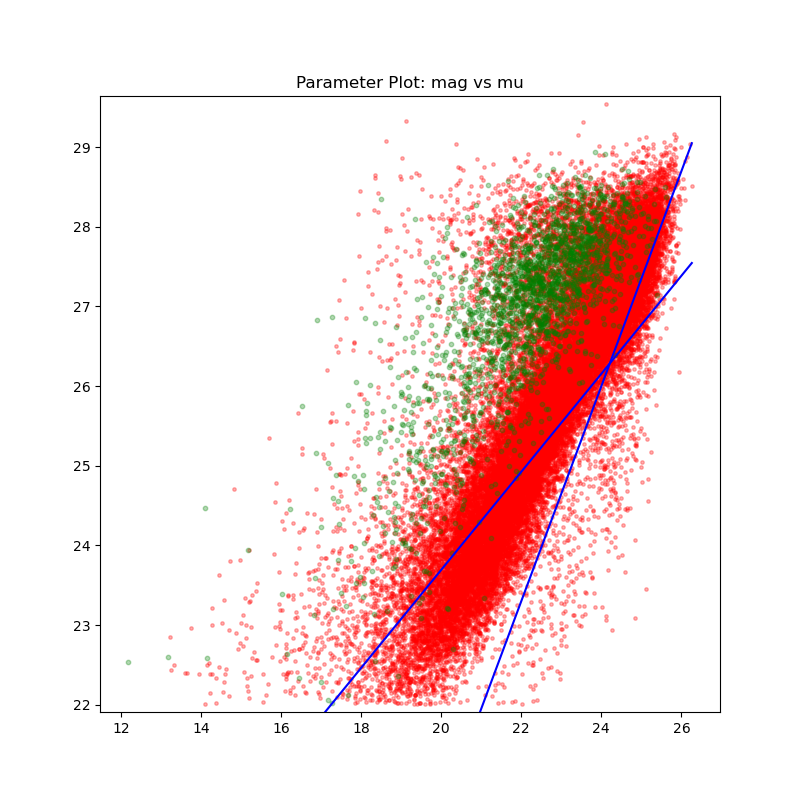

In [18]:
%matplotlib widget

band = 'cfis_lsb-r'

if band == 'whigs-g':
    a, b = 0.7063, 9.4420
    a1, b1 = 4.1000, -78.0000
    df_dwarf, df_other = df_dwarf_g, df_other_g
    training_data = training_data_g
elif band == 'cfis_lsb-r':
    a, b = 0.6155, 11.3832
    a1, b1 = 1.3500, -6.4000
    df_dwarf, df_other = df_dwarf_r, df_other_r
    training_data = training_data_r
elif band == 'ps-i':
    a, b = 0.5351, 13.1425
    a1, b1 = 3.5000, -61.0000
    df_dwarf, df_other = df_dwarf_i, df_other_i
    training_data = training_data_i

param1, param2 = 'mag', 'mu' #('r_100_arcsec','r_90_arcsec') # 0.5952, 12.5157
plot_params(df_dwarf, df_other, param1, param2, func_type='linear', func_params=[a, b], func_params1=[a1, b1], annotate=False, plot_func=True, print_filtered=False)

Available function types: linear, polynomial, exponential, modified-exp, sigmoid-exp, steep-fall


Enter the function type you want to use:  linear
Enter conservativeness (0-1, default 0.95):  
Enter positive weight (default 10):  


Extracted linear parameters: coefficient = -0.0428, intercept = 2.0839

Linear separation line equation:
r_90_arcsec_r_75_arcsec = max(-0.0428*mag + 2.0839, 0)

Sensitivity (True Positive Rate): 0.0455
Specificity (True Negative Rate): 0.9838
Positive Predictive Value: 0.1236
xlim: 10.874303747278983/28.34337684338994, ylim: 0.9826623468835547/2.4315627545873926


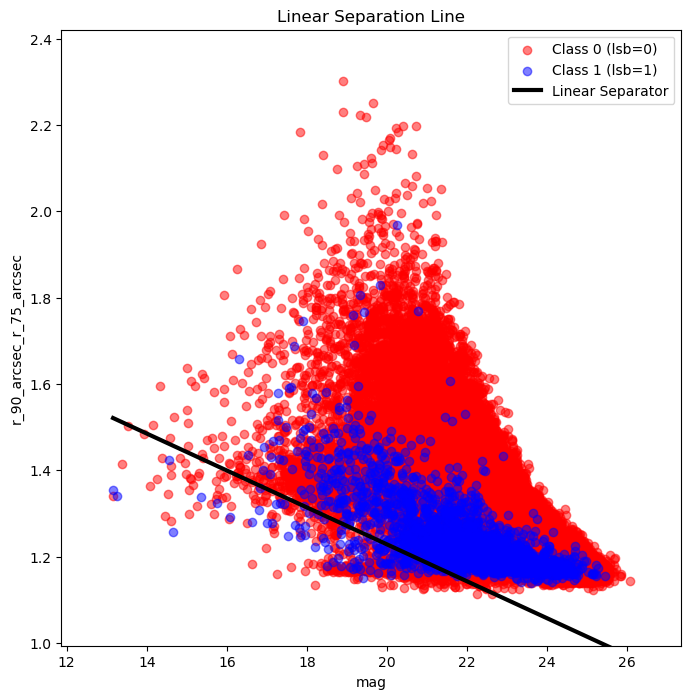


Are you satisfied with the fit? (yes/no):  yes



Final separator function:
r_90_arcsec_r_75_arcsec = max(-0.0428*mag + 2.0839, 0)


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
%matplotlib inline

def sigmoid_exp_func(x, a, b, c, d, e):
    return a / (1 + np.exp(b * (x - c))) * np.exp(-d * x) + e

def steep_fall(x, a, b):
    return a * np.exp(-b * x) / x

def find_separator(X, y, param1, param2, func_type='modified-exp', degree=3, positive_weight=10, conservativeness=0.95):
    sorted_indices = np.argsort(X[:, 0])
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    decision_points = []
    weights = []
    for i in range(1, len(y_sorted)):
        if y_sorted[i] != y_sorted[i-1]:
            mid_point = (X_sorted[i] + X_sorted[i-1]) / 2
            decision_points.append(mid_point)
            weights.append(positive_weight if y_sorted[i] == 1 else 1)
    decision_points = np.array(decision_points)
    weights = np.array(weights)

    if func_type == 'linear':
        coeffs = np.polyfit(decision_points[:, 0], decision_points[:, 1], 1, w=weights)
        sep_func = lambda x: np.maximum(coeffs[0] * x + coeffs[1], 0)
        equation = f"max({coeffs[0]:.4f}*{param1} + {coeffs[1]:.4f}, 0)"

    elif func_type == 'polynomial':
        def poly_exp_func(x, *coeffs):
            return np.exp(np.polyval(coeffs, x))
        
        p0 = np.polyfit(decision_points[:, 0], np.log(decision_points[:, 1]), degree)
        
        popt, _ = curve_fit(poly_exp_func, decision_points[:, 0], decision_points[:, 1], 
                            p0=p0, sigma=1/weights, maxfev=10000)
        
        sep_func = lambda x: poly_exp_func(x, *popt)
        equation = "exp(" + " + ".join([f"{popt[i]:.4f}*{param1}^{len(popt)-i-1}" for i in range(len(popt))]) + ")"

    elif func_type == 'exponential':
        def exp_func(x, a, b, c):
            return a * np.exp(-b * x) + c
        
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
        
        a_guess = y_max - y_min
        b_guess = 1 / (x_max - x_min)
        c_guess = y_min

        lower_bounds = [0, 0, 0]
        upper_bounds = [np.inf, np.inf, y_min]

        popt, _ = curve_fit(exp_func, decision_points[:, 0], decision_points[:, 1], 
                            p0=[a_guess, b_guess, c_guess], 
                            bounds=(lower_bounds, upper_bounds),
                            maxfev=10000)
        
        sep_func = lambda x: exp_func(x, *popt)
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) + {popt[2]:.4f}"

    elif func_type == 'modified-exp':
        def modified_exp_func(x, a, b, c, d):
            return a * np.exp(-b * (x ** c)) + d
        
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
        
        a_guess = y_max - y_min
        b_guess = 1 / (x_max - x_min)
        c_guess = 1
        d_guess = y_min

        lower_bounds = [0, 0, 0.1, 0]
        upper_bounds = [np.inf, np.inf, 2, y_min]

        try:
            popt, _ = curve_fit(modified_exp_func, decision_points[:, 0], decision_points[:, 1], 
                                p0=[a_guess, b_guess, c_guess, d_guess], 
                                bounds=(lower_bounds, upper_bounds),
                                maxfev=50000)  # Increased max iterations
            
            sep_func = lambda x: modified_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * ({param1} ** {popt[2]:.4f})) + {popt[3]:.4f}"
        except RuntimeError:
            print("Modified exponential fit failed. Falling back to simple exponential.")
            return find_separator(X, y, param1, param2, 'exponential', degree, positive_weight, conservativeness)
    elif func_type == 'sigmoid-exp':
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
        
        a_guess = y_max - y_min
        b_guess = 1
        c_guess = (x_max + x_min) / 2
        d_guess = 0.1
        e_guess = y_min

        lower_bounds = [0, 0, x_min, 0, 0]
        upper_bounds = [np.inf, np.inf, x_max, np.inf, y_min]

        try:
            popt, _ = curve_fit(sigmoid_exp_func, decision_points[:, 0], decision_points[:, 1], 
                                p0=[a_guess, b_guess, c_guess, d_guess, e_guess], 
                                bounds=(lower_bounds, upper_bounds),
                                maxfev=50000)
            
            sep_func = lambda x: sigmoid_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} / (1 + exp({popt[1]:.4f} * ({param1} - {popt[2]:.4f}))) * exp(-{popt[3]:.4f} * {param1}) + {popt[4]:.4f}"
        except RuntimeError:
            print("Sigmoid-exponential fit failed. Falling back to modified exponential.")
            return find_separator(X, y, param1, param2, 'modified-exp', degree, positive_weight, conservativeness)
    elif func_type == 'steep-fall':
        y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
        x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])

        a_guess = y_max - y_min
        b_guess = 1 / (x_max - x_min)

        lower_bounds = [0, 0]
        upper_bounds = [np.inf, np.inf]

        try:
            popt, _ = curve_fit(steep_fall, decision_points[:, 0], decision_points[:, 1], 
                                p0=[a_guess, b_guess], 
                                bounds=(lower_bounds, upper_bounds),
                                maxfev=50000)
            
            sep_func = lambda x: steep_fall(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) / {param1}"
        except RuntimeError:
            print("Steep fall fit failed. Falling back to exponential.")
            return find_separator(X, y, param1, param2, 'exponential', degree, positive_weight, conservativeness)
    else:
        raise ValueError("Invalid function type. Choose 'linear', 'polynomial', 'exponential', or 'modified-exp'.")

    # Apply conservativeness adjustment
    positive_examples = X[y == 1]
    distances = positive_examples[:, 1] - sep_func(positive_examples[:, 0])
    adjustment = np.percentile(distances[distances < 0], (1 - conservativeness) * 100)

    # Adjust the function
    if func_type == 'linear':
        coeffs[1] += adjustment
        sep_func = lambda x: np.maximum(coeffs[0] * x + coeffs[1], 0)
        equation = f"max({coeffs[0]:.4f}*{param1} + {coeffs[1]:.4f}, 0)"
    elif func_type == 'polynomial':
        popt[-1] += adjustment
        sep_func = lambda x: poly_exp_func(x, *popt)
        equation = "exp(" + " + ".join([f"{popt[i]:.4f}*{param1}^{len(popt)-i-1}" for i in range(len(popt))]) + ")"
    elif func_type in ['exponential', 'modified-exp', 'sigmoid-exp', 'steep-fall']:
        popt[0] *= (1 + adjustment / popt[0])
        if func_type == 'exponential':
            sep_func = lambda x: exp_func(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) + {popt[2]:.4f}"
        elif func_type == 'modified-exp':
            sep_func = lambda x: modified_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * ({param1} ** {popt[2]:.4f})) + {popt[3]:.4f}"
        elif func_type == 'sigmoid-exp':
            sep_func = lambda x: sigmoid_exp_func(x, *popt)
            equation = f"{popt[0]:.4f} / (1 + exp({popt[1]:.4f} * ({param1} - {popt[2]:.4f}))) * exp(-{popt[3]:.4f} * {param1}) + {popt[4]:.4f}"
        else:  # steep-fall
            sep_func = lambda x: steep_fall(x, *popt)
            equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) / {param1}"

    return sep_func, equation

def evaluate_separator(X, y, sep_func):
    y_pred = sep_func(X[:, 0]) > X[:, 1]
    true_positives = np.sum((y == 1) & (y_pred == 1))
    false_negatives = np.sum((y == 1) & (y_pred == 0))
    true_negatives = np.sum((y == 0) & (y_pred == 0))
    false_positives = np.sum((y == 0) & (y_pred == 1))
    
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    positive_predictive_value = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    return sensitivity, specificity, positive_predictive_value

def plot_separator(X, y, sep_func, param1, param2, func_type):
    plt.close('all')
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class 0 (lsb=0)', alpha=0.5)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', label='Class 1 (lsb=1)', alpha=0.5)

    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
    plt.plot(x_range, sep_func(x_range), color='black', lw=3, label=f'{func_type.capitalize()} Separator')

    xinterval = X[:, 0].max() - X[:, 0].min()
    yinterval = X[:, 1].max() - X[:, 1].min()
    
    plt.xlim(X[:, 0].min()-(xinterval/10), X[:, 0].max()+(xinterval/10))
    plt.ylim(X[:, 1].min()-(yinterval/10), X[:, 1].max()+(yinterval/10))
    print(f'xlim: {X[:, 0].min()-(X[:, 0].mean()/10)}/{X[:, 0].max()+(X[:, 0].mean()/10)}, ylim: {X[:, 1].min()-(X[:, 1].mean()/10)}/{X[:, 1].max()+(X[:, 1].mean()/10)}')
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.legend()
    plt.title(f'{func_type.capitalize()} Separation Line')
    plt.show()

def adjust_parameters(func_type, popt, param1):
    print("\nCurrent parameters:")
    for i, param in enumerate(popt):
        print(f"Parameter {i}: {param:.6f}")
    
    while True:
        index = input("\nEnter the index of the parameter you want to adjust (or 'done' to finish): ")
        if index.lower() == 'done':
            break
        try:
            index = int(index)
            if 0 <= index < len(popt):
                new_value = float(input(f"Enter new value for parameter {index} (current: {popt[index]:.6f}): "))
                popt[index] = new_value
            else:
                print("Invalid index. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number or 'done'.")
    
    if func_type == 'linear':
        sep_func = lambda x: np.maximum(popt[0] * x + popt[1], 0)
        equation = f"max({popt[0]:.4f}*{param1} + {popt[1]:.4f}, 0)"
    elif func_type == 'polynomial':
        sep_func = lambda x: np.exp(np.polyval(popt, x))
        equation = "exp(" + " + ".join([f"{popt[i]:.4f}*{param1}^{len(popt)-i-1}" for i in range(len(popt))]) + ")"
    elif func_type == 'exponential':
        sep_func = lambda x: popt[0] * np.exp(-popt[1] * x) + popt[2]
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) + {popt[2]:.4f}"
    elif func_type == 'modified-exp':
        sep_func = lambda x: popt[0] * np.exp(-popt[1] * (x ** popt[2])) + popt[3]
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * ({param1} ** {popt[2]:.4f})) + {popt[3]:.4f}"
    elif func_type == 'sigmoid-exp':
        sep_func = lambda x: sigmoid_exp_func(x, *popt)
        equation = f"{popt[0]:.4f} / (1 + exp({popt[1]:.4f} * ({param1} - {popt[2]:.4f}))) * exp(-{popt[3]:.4f} * {param1}) + {popt[4]:.4f}"
    elif func_type == 'steep-fall':
        sep_func = lambda x: steep_fall(x, *popt)
        equation = f"{popt[0]:.4f} * exp(-{popt[1]:.4f} * {param1}) / {param1}"
    
    return sep_func, equation, popt

def add_fraction_to_df(df, param1, param2, log=False):
    df_mod = df.copy()
    if log:
        df_mod[f'log_{param1}_{param2}'] = np.log(np.divide(df_mod[param1].values.astype(np.float32), df_mod[param2].values.astype(np.float32), where=df_mod[param2] !=0, out=np.zeros_like(df_mod[param1].values.astype(np.float32))))
    else:
        df_mod[f'{param1}_{param2}'] = df_mod[param1].values.astype(np.float32)/df_mod[param2].values.astype(np.float32)
    return df_mod

def add_log_to_df(df, param):
    df_mod = df.copy()
    df_mod[f'log_{param}'] = np.log(df_mod[param].values)
    return df_mod

def main(df, param1, param2, class_column):
    X = df[[param1, param2]].values
    y = df[class_column].values

    func_types = ['linear', 'polynomial', 'exponential', 'modified-exp', 'sigmoid-exp', 'steep-fall']
    print("Available function types:", ", ".join(func_types))
    chosen_type = input("Enter the function type you want to use: ").lower()

    if chosen_type not in func_types:
        print("Invalid function type. Defaulting to modified-exp.")
        chosen_type = 'modified-exp'

    conservativeness = float(input("Enter conservativeness (0-1, default 0.95): ") or 0.95)
    positive_weight = float(input("Enter positive weight (default 10): ") or 10)

    if chosen_type == 'polynomial':
        degree = int(input("Enter the degree of the polynomial (default is 3): ") or 3)
        sep_func, equation = find_separator(X, y, param1, param2, chosen_type, degree=degree, 
                                            positive_weight=positive_weight, conservativeness=conservativeness)
    else:
        sep_func, equation = find_separator(X, y, param1, param2, chosen_type, 
                                            positive_weight=positive_weight, conservativeness=conservativeness)
    
    # Extract parameters from the equation
    if chosen_type == 'linear':
        # More robust extraction method for linear function
        parts = equation.split('max(')[1].split(')')[0].split(',')
        linear_part = parts[0].strip()
        if '*' in linear_part:
            coefficient, rest = linear_part.split('*')
            coefficient = float(coefficient)
        else:
            coefficient = 1.0
            rest = linear_part
        
        rest_parts = rest.split('+')
        if len(rest_parts) > 1:
            intercept = float(rest_parts[1].strip())
        else:
            intercept = 0.0
        
        popt = [coefficient, intercept]
        print(f"Extracted linear parameters: coefficient = {coefficient}, intercept = {intercept}")
    elif chosen_type == 'polynomial':
        popt = [float(x.split('*')[0]) for x in equation.split('exp(')[1].split(')')[0].split('+')]
    elif chosen_type == 'exponential':
        match = re.search(r'(\d+\.\d+)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*' + re.escape(param1) + r'\)\s*\+\s*(\d+\.\d+)', equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2)), float(match.group(3))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")
    elif chosen_type == 'modified-exp':
        match = re.search(r'(\d+\.\d+)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*\(' + re.escape(param1) + r'\s*\*\*\s*(\d+\.\d+)\)\)\s*\+\s*(\d+\.\d+)', equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2)), float(match.group(3)), float(match.group(4))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")
    elif chosen_type == 'sigmoid-exp':
        match = re.search(r'(\d+\.\d+)\s*/\s*\(1\s*\+\s*exp\((\d+\.\d+)\s*\*\s*\(' + re.escape(param1) + r'\s*-\s*(\d+\.\d+)\)\)\)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*' + re.escape(param1) + r'\)\s*\+\s*(\d+\.\d+)', equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2)), float(match.group(3)), float(match.group(4)), float(match.group(5))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")
    elif chosen_type == 'steep-fall':
        match = re.search(r'(\d+\.\d+)\s*\*\s*exp\(-(\d+\.\d+)\s*\*\s*' + re.escape(param1) + r'\)\s*/\s*' + re.escape(param1), equation)
        if match:
            popt = [float(match.group(1)), float(match.group(2))]
        else:
            raise ValueError("Unable to extract parameters from the equation.")

    while True:
        sensitivity, specificity, ppv = evaluate_separator(X, y, sep_func)
        
        print(f"\n{chosen_type.capitalize()} separation line equation:")
        print(f"{param2} = {equation}")
        print(f"\nSensitivity (True Positive Rate): {sensitivity:.4f}")
        print(f"Specificity (True Negative Rate): {specificity:.4f}")
        print(f"Positive Predictive Value: {ppv:.4f}")
        
        plot_separator(X, y, sep_func, param1, param2, chosen_type)
        
        satisfied = input("\nAre you satisfied with the fit? (yes/no): ").lower()
        if satisfied == 'yes':
            break
        
        sep_func, equation, popt = adjust_parameters(chosen_type, popt, param1)

    print("\nFinal separator function:")
    print(f"{param2} = {equation}")

# Define column names
PARAM1 = 'mag'
log_param1 = False
PARAM2 = 'r_90_arcsec_r_75_arcsec'
log_param2 = False
CLASS_COLUMN = 'lsb'
# Run the analysisparam
if __name__ == "__main__":
    training_data_mod = training_data_i[training_data_i['r_10_arcsec'] > 0.].reset_index(drop=True)
    training_data_mod = training_data_mod[training_data_mod['r_25_arcsec'] > 0.].reset_index(drop=True)
    # training_data_mod = training_data_i[training_data_i['mu_median'] > 0.].reset_index(drop=True)
    training_data_mod = add_fraction_to_df(training_data_mod, 'r_90_arcsec', 'r_75_arcsec', log=log_param2)
    # training_data_mod = add_fraction_to_df(training_data_mod, 're_arcsec', 'r_10_arcsec', log=False)
    if log_param1:
        training_data_mod = add_log_to_df(training_data_mod, 'mag')
    main(training_data_mod, PARAM1, PARAM2, CLASS_COLUMN)

In [93]:
def filter_candidates(df, band):
    df_mod = df.copy()
    df_dwarf = df.loc[df['lsb'] == 1].reset_index(drop=True)

    # Define band-specific conditions
    band_conditions = {
        'cfis_lsb-r': {
            'basic': {
                'mu': (22.0, None),  # (min, max), None means no limit
                're_arcsec': (1.6, 55.0),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.353, 18.2),
                'r_25_arcsec': (0.4, 32.1),
                'r_75_arcsec': (2.16, 102.1),
                'r_90_arcsec': (2.5, 145.1),
                'r_100_arcsec': (2.8, 254.1),
                'r_fwhm_arcsec': (0.4, 13.8),
                'mu_median': (0.34, 28.7),
                'mu_mean': (0.4, 65.1),
                'mu_max': (2.0, 6255.0),
                'total_flux': (55, None),
                'mag': (12.17, 25.7),
            },
            'complex': [
                lambda df_mod: (df_mod['mu'] > (0.6155 * df_mod['mag'] + 11.3832))
                & (df_mod['mu'] > (1.35 * df_mod['mag'] - 6.4)),
                lambda df_mod: (df_mod['mu'] / df_mod['r_75_arcsec'])
                < np.maximum(1.51 * df_mod['mag'] - 24.6, 3.0),
                lambda df_mod: np.log(df_mod['r_90_arcsec'] / df_mod['r_75_arcsec'])
                < (0.295 * np.log(df_mod['r_100_arcsec']) - 0.13),
            ],
        },
        'whigs-g': {
            'basic': {
                'mu': (22.51, None),  # (min, max), None means no limit
                're_arcsec': (1.6, None),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.4, 8.1),
                'r_25_arcsec': (0.72, 15.0),
                'r_75_arcsec': (2.17, 42.0),
                'r_90_arcsec': (2.47, 54.0),
                'r_100_arcsec': (2.8, 79.0),
                'r_fwhm_arcsec': (0.417, 13.5),
                'mu_median': (0.0072, 0.8),
                'mu_mean': (0.017, 2.01),
                'mu_max': (0.066, 226.0),
                'total_flux': (1.77, None),
                'mag': (16.0, 26.5),
            },
            'complex': [
                lambda df_mod: (df_mod['mu'] > (0.7063 * df_mod['mag'] + 9.4420))
                & (df_mod['mu'] > (4.1 * df_mod['mag'] - 78.0)),
                lambda df_mod: np.log(df_mod['r_100_arcsec'] / df_mod['r_90_arcsec'])
                < (-1.2615 * np.log(df_mod['mag']) + 4.3000),
                lambda df_mod: np.log(df_mod['mag'] / df_mod['r_75_arcsec'])
                < np.maximum(6.4500 * np.log(df_mod['mag']) + -17.9000, 0.75),
            ],
        },
        'ps-i': {
            'basic': {
                'mu': (22.0, 29.5),  # (min, max), None means no limit
                're_arcsec': (1.6, 40.0),
                'axis_ratio': (0.17, None),
                'r_10_arcsec': (0.4, 14.95),
                'r_25_arcsec': (0.58, 25.5),
                'r_75_arcsec': (2.1, 58.0),
                'r_90_arcsec': (2.5, 77.0),
                'r_100_arcsec': (2.7, 117.0),
                'r_fwhm_arcsec': (0.4, 20.8),
                'mu_median': (0.445, 40.7),
                'mu_mean': (0.565, 100.8),
                'mu_max': (2.47, 4465.0),
                'total_flux': (66.0, None),
                'mag': (13.1, 26.0),
            },
            'complex': [
                lambda df_mod: (df_mod['r_90_arcsec'] / df_mod['r_75_arcsec'])
                < (0.0100 * df_mod['r_100_arcsec'] + 1.4000),
                lambda df_mod: (df_mod['r_100_arcsec'] / df_mod['r_90_arcsec'])
                < (-0.0850 * df_mod['mag'] + 3.3000),
                lambda df_mod: (df_mod['mag'] / df_mod['r_75_arcsec'])
                < np.maximum(1.4 * df_mod['mag'] - 23, 2.5),
                lambda df_mod: (df_mod['r_90_arcsec'] / df_mod['r_75_arcsec'])
                < (-0.0700 * df_mod['mag'] + 2.97),
                lambda df_mod: (df_mod['r_75_arcsec'] / df_mod['r_25_arcsec'])
                < (0.2 * df_mod['mag'] + 1.0),
                lambda df_mod: (df_mod['r_75_arcsec'] / df_mod['r_25_arcsec'])
                < (-1.1 * df_mod['mag'] + 30.5),
                lambda df_mod: np.log(df_mod['r_100_arcsec'] / df_mod['r_75_arcsec'])
                < (-2.7 * np.log(df_mod['mag']) + 9.05),
                lambda df_mod: np.log(df_mod['r_75_arcsec'] / df_mod['r_25_arcsec'])
                < (-0.9631 * np.log(df_mod['mag']) + 4.5500),
                lambda df_mod: np.log(df_mod['r_75_arcsec'] / df_mod['r_25_arcsec'])
                < (0.8 * np.log(df_mod['mag']) -0.81),
            ],
        },
    }

    if band not in band_conditions:
        logger.error(f'Conditions not implemented for band {band}.')
        return None

    conditions = band_conditions[band]

    # Apply basic conditions
    for column, (min_val, max_val) in conditions['basic'].items():
        if min_val is not None:
            df_mod = df_mod[df_mod[column] > min_val]
        if max_val is not None:
            df_mod = df_mod[df_mod[column] < max_val]

    # Apply complex conditions
    for condition in conditions['complex']:
        df_mod = df_mod[condition]

    # Reset index
    df_mod = df_mod.reset_index(drop=True)

    print(
        f'Filtered out {len(df.loc[df["lsb"]==1])-len(df_mod.loc[df_mod["lsb"]==1])}/{len(df_dwarf)} dwarfs.'
    )
    print(
        f'Filtered out {len(df.loc[df["lsb"]==0])-len(df_mod.loc[df_mod["lsb"]==0])}/{len(df.loc[df["lsb"]==0])} other objects.'
    )

    return df_mod

In [94]:
# min_max = df_dwarf_i.agg(['min', 'max'])
# min_max_df = min_max[['r_10_arcsec', 'r_25_arcsec', 're_arcsec', 'r_fwhm_arcsec', 'r_75_arcsec', 'r_90_arcsec', 'r_100_arcsec', 'mu_max', 'mu_median', 'mu_mean', 'axis_ratio', 'mag', 'mu', 'total_flux']]
# min_max_df

In [95]:
# %matplotlib widget
# plt.figure()
# plt.hist(df_dwarf_i['r_10_arcsec'].values, bins=100)
# plt.show()

In [99]:
band = 'whigs-g'

if band == 'whigs-g':
    a, b = 0.7063, 9.4420
    a1, b1 = 4.1000, -78.0000
    df_dwarf, df_other = df_dwarf_g, df_other_g
    training_data = training_data_g
elif band == 'cfis_lsb-r':
    a, b = 0.6155, 11.3832
    a1, b1 = 1.3500, -6.4000
    df_dwarf, df_other = df_dwarf_r, df_other_r
    training_data = training_data_r
elif band == 'ps-i':
    a, b = 0.5351, 13.1425
    a1, b1 = 3.5000, -61.0000
    df_dwarf, df_other = df_dwarf_i, df_other_i
    training_data = training_data_i

In [100]:
# filtered_df = check_param_filter(training_data, a, b, band=band, a1=a1, b1=b1)

In [105]:
filter_candidates(training_data_r, band='cfis_lsb-r')

Filtered out 26/2088 dwarfs.
Filtered out 17586/41760 other objects.


,ID,X,Y,A,B,theta,total_flux,mu_max,mu_median,mu_mean,...,axis_ratio,mag,mu,class_label,zspec,lsb,ID_known,example_id,associated_lsb_ra,associated_lsb_dec
0,1978,26.98333,2249.4016,19.978848,8.748549,-1.043862,8122.554000,16.390736,1.370736,2.314118,...,0.437891,20.225768,26.259254,2.0,0.002801,1.0,1100400+294225,287.239.1978,NaN,NaN
1,2021,66.18597,2352.6787,2.898089,2.002676,1.421447,305.408750,12.929903,1.205671,2.331365,...,0.691033,23.787796,26.631885,NaN,NaN,0.0,NaN,287.239.2021,165.165606,29.706097
2,2119,209.20132,2443.4720,4.185191,2.513891,0.079095,970.349850,44.654840,0.891345,3.213079,...,0.600663,22.532679,25.581267,NaN,NaN,0.0,NaN,287.239.2119,165.165606,29.706097
3,1570,114.27787,1784.2384,3.001048,2.823960,0.429194,1990.994900,71.108090,2.028016,6.340748,...,0.940991,21.752325,25.556323,NaN,NaN,0.0,NaN,287.239.1570,165.165606,29.706097
4,1584,288.50626,1790.5854,3.517763,2.293700,0.315786,1730.094500,73.736725,2.058362,6.028204,...,0.652034,21.904825,25.042510,NaN,NaN,0.0,NaN,287.239.1584,165.165606,29.706097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26231,809,552.14520,1287.3801,3.693300,2.754660,1.548141,1405.772200,79.400000,1.137086,4.534749,...,0.745853,22.130213,25.057187,3.0,0.239652,0.0,NaN,190.272.809,137.040438,45.910427
26232,841,471.74097,1365.8252,4.461684,2.871095,-0.857716,696.457400,51.597614,1.058433,2.149560,...,0.643500,22.892764,25.971823,2.0,0.494622,0.0,NaN,190.272.841,137.040438,45.910427
26233,712,673.18005,1160.8265,3.366931,2.787978,1.033751,1382.208500,57.204254,1.418110,4.936459,...,0.828047,22.148566,25.356412,2.0,0.295240,0.0,NaN,190.272.712,137.040438,45.910427
26234,966,266.02762,1565.6519,5.001325,2.788152,0.951166,112.791534,9.015820,0.788604,0.917004,...,0.557483,24.869309,27.418169,NaN,NaN,0.0,NaN,190.272.966,137.040438,45.910427


# Check cutouts

In [174]:
cutout_file = read_h5('/arc/projects/unions/ssl/data/raw/tiles/dwarforge/378_270/gri/378_270_matched_cutouts.h5')

In [175]:
378_270

378270

In [160]:
cutout_file['images'].shape

(14, 3, 64, 64)

In [182]:
cutouts = cutout_file['images'][:,0,:]

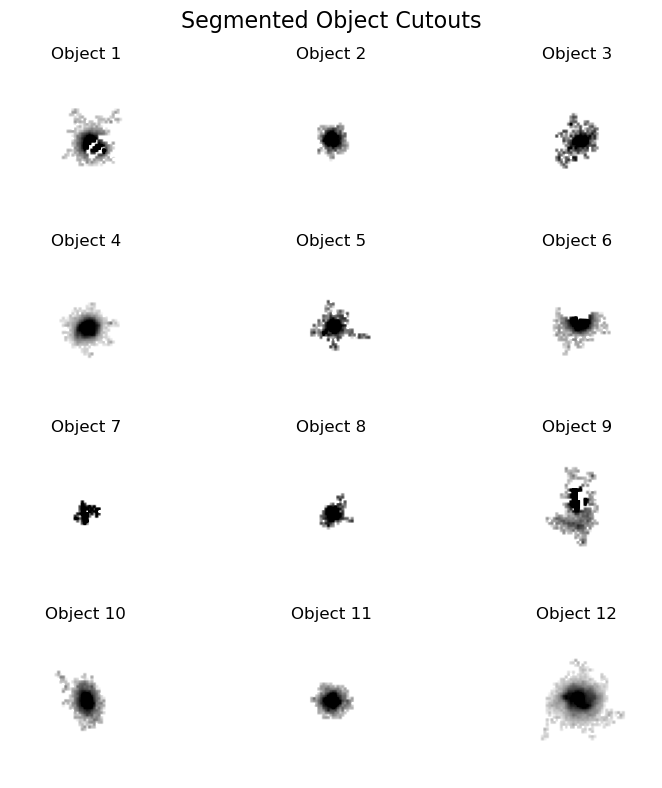

In [183]:
plot_cutouts(cutouts, num_cutouts=25)

In [14]:
from glob import glob
from vos import Client

def gather_cutout_data(parent_dir_source, parent_dir_destination, band='cfis_lsb-r'):
    pattern = os.path.join(parent_dir_source, "*_*", band, "*.r_cutouts.h5")
#     pattern = os.path.join(parent_dir_source, band, "*.r_cutouts.h5")
    cutout_files = Client().glob(pattern)
    print(len(cutout_files))
    for file in tqdm(cutout_files[:10]):
        try:
            filename = os.path.basename(file)
            name, ext = os.path.splitext(filename)
            tile_numbers = filename.split('.')[1:3]
            tile_id = f'{tile_numbers[0].zfill(3)}_{tile_numbers[1].zfill(3)}'
            dir_destination = os.path.join(parent_dir_destination, tile_id, band)
            os.makedirs(dir_destination, exist_ok=True)
            temp_path = os.path.join(dir_destination, name+'_temp'+ext)
            final_path = os.path.join(dir_destination, filename)
            
            print(f'Downloading {filename} for band {band}...')
            
            result = subprocess.run(
            f'vcp -v {file} {temp_path}', shell=True, stderr=subprocess.PIPE, text=True)

            result.check_returncode()

            os.rename(temp_path, final_path)
            
            print(f'Successfully downloaded {filename} for band {band} to {dir_destination}.')
            
        except Exception as e:
            print(f"Error downloading file {file}: {str(e)}")
            continue

In [13]:
parent_dir_source = 'arc:/projects/unions/ssl/data/raw/tiles/dwarforge' 
parent_dir_destination = '/home/nick/astro/DwarForge/data'

gather_cutout_data(parent_dir_source, parent_dir_destination, band='cfis_lsb-r')

KeyboardInterrupt: 

### Cleanup

In [44]:
def delete_file(file_path):
    try:
        os.remove(file_path)
        # print(f'File {os.path.split(file_path)[1]} has been deleted successfully')
    except FileNotFoundError:
        print(f'File {os.path.split(file_path)[1]} does not exist')
    except PermissionError:
        print(f'Permission denied: unable to delete {os.path.split(file_path)[1]}')
    except Exception as e:
        print(f'An error occurred while deleting the file: {e}')

def delete_segmaps(parent_folder, in_dict, band='cfis_lsb-r'):
    zfill = in_dict[band]['zfill']
    file_prefix = in_dict[band]['name']
    delimiter = in_dict[band]['delimiter']
    suffix = in_dict[band]['suffix']
    pattern = os.path.join(parent_folder, "*_*", band, f"{file_prefix}{delimiter}*{suffix}_rebin_star_mask*_seg.fits")

    segmap_filepaths = []
    for file in tqdm(glob(pattern)):
        # segmap_filepaths.append(file)
        delete_file(file)

    return segmap_filepaths

In [45]:
seg_paths = delete_segmaps(data_dir, in_dict=band_dict, band='ps-i')

  0%|          | 0/20580 [00:00<?, ?it/s]

In [34]:
len(seg_paths)

43